This notebook is part of the flood-detection workflow. 
    - **Import DG image downloaded from GBDX platform
    - Convert geotiff files to numpy array via rasterio
    - Scale to surface reflectance values (divide by 10,000)
    - Define individual bands for later calculations
    - Calculate indices (NDVI, multiple versions of NDWI) and dark parameter
    - Threshold and plot based on Cloud to Street algorithm
    - Calculate MSI and MBI
    - Threshold and plot NDVI, NDWI and MSI**
    - Compare output to Cloud-to-Street results
    - Validate output based on reference data
    - Use as inputs to explore supervised and unsupervised learning modules. 
    
Bolded items are completed within this notebook. 

List of acronyms:
NDWI : Normalized difference water index
NDVI : Normalized difference vegetation index
MSI : Morphological shadow index
MBI : Morphological building index

This notebook calculates and plots NDVI, a "dark" parameter (defined below) and several formulations of NDWI as defined within the notebook. Cloud and flood plots are produced in part based on the algorithm provided by Cloud to Street:

**Final algorithm from Cloud-to-Street for Abidjan image:**

**Clouds:** C ≥ 0.25 and RE  ≥ 0.25

**Flood:**

(NDWI1 ≥ 0.03, DARK ≤ 5, C ≤ 1, and R ≤ 0.85 ) or *check with Jeff re NDWI1 threshold. replaced with 0.03 for now

(NDWI2 ≥ 0.03, DARK ≤ 5.8, C ≤ 1)

*Note that thresholds vary slightly as this notebook was developed for pan-sharpened imagery while the original Cloud to Street algorithm was developed for non-pansharpened imagery. 

DARK = RE + NIR1 + NIR2

This notebook also calculates the MSI based on Huang et al. (2012). The calculation utilizes the scikit-image blacktop hat package. 

**References**
Huang, X., Xie, C., Fang, X., Zhang, L. (2015) Combining Pixel-and Object-Based Machine Learning for Identification of Water-Body Types from Urban High-Resolution Remote-Sensing Imagery. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 8, 2097–2110.

Huang, X., and Zhang, L. (2012) Morphological Building/Shadow Index for Building Extraction From High-Resolution
Imagery Over Urban Areas. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 5, 161-172.

Xie, C., Huang, X., Zeng, W., & Fang, X. (2016). A novel water index for urban high-resolution eight-band WorldView-2 imagery. International Journal of Digital Earth, 9(10), 925–941.

Cloud to Street. Urban Flood Mapping Using Very-High Resolution Satellite Imagery. Available at: https://abidjan.cloudtostreet.info/info

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
from glob import glob
import pickle
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es

# Import modules with custom functions
import sys
sys.path.insert(0, '..\\modules\\')
import calc_array_mask_test
import morph_indices

### Note: update "aoi" parameter and band_path with directory name for imagery of interest

In [3]:
# Identify area of interest (aoi), set directories for inputs and outputs
aoi = "southeast_ps"

# Checks for existing imagery directory
band_path = '..\\data\\'+aoi+"\\"
try:
    os.makedirs(band_path)
except FileExistsError:
    print("band_path directory already exists!")

# Checks for existing outputs directory for raster files
outputs_path= os.path.join(band_path, "explorations_outputs\\raster_files\\")
try:
    os.makedirs(outputs_path)
except FileExistsError:
    print("outputs_path directory already exists!")

band_path directory already exists!


In [4]:
# Create raster stack of all spectral bands
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                             all_bands_path)

In [5]:
# Open raster stack and make copies of meta file for use in writing out files later
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
    masks_out_meta = src.meta.copy()
    stack_out_meta = src.meta.copy()
    files_out_meta_test = src.meta.copy()

In [6]:
# Update files_out_meta for writing out single files
files_out_meta['count']=1
files_out_meta_test['count']=1
files_out_meta_test['nodata']=-99999
# _test NDVI, NDWI, MSI files saved without using 'nodata' = -9999
# files_out_meta['nodata']=-9999

# Update masks_out_meta for writing single integer type files
masks_out_meta['dtype'] = 'int32'
masks_out_meta['count'] = 1

# Update stack_out_meta for writing out cloud masked band stack
stack_out_meta['nodata']=-99999

In [7]:
# Scale raster stack to surface reflectance values (should be between 0 and 1)
all_bands_scaled = all_bands_stack/10000

In [8]:
# Plot histogram to explore scaled value distribution 
# fig,ax = plt.subplots()
# plt.hist(all_bands_scaled.ravel());

In [9]:
# Read in scaled bands
coastal_scaled = all_bands_scaled[0]
blue_scaled = all_bands_scaled[1]
green_scaled = all_bands_scaled[2]
yellow_scaled = all_bands_scaled[3]
red_scaled = all_bands_scaled[4]
rededge_scaled = all_bands_scaled[5]
nearir1_scaled = all_bands_scaled[6]
nearir2_scaled = all_bands_scaled[7]

In [10]:
# with rio.open(outputs_path+'raw_coastal_scaled.tif', 'w', **files_out_meta) as dst:
#     dst.write(coastal_scaled,1)

# Calculate NDWI, NDVI and DARK parameters

In [11]:
ndwi0 = es.normalized_diff(b1=green_scaled, b2=nearir1_scaled)  
ndwi1 = es.normalized_diff(b1=coastal_scaled, b2=nearir2_scaled)
ndwi2 = es.normalized_diff(b1= yellow_scaled, b2=nearir2_scaled)
ndvi = es.normalized_diff(b1=nearir1_scaled, b2= red_scaled)
dark = rededge_scaled + nearir1_scaled + nearir2_scaled
# cloud_shadow = nearir1_scaled/blue_scaled

In [12]:
# Calculate NDWI values
ndwi0 = es.normalized_diff(b1=green_scaled, b2=nearir1_scaled)  
ndwi1 = es.normalized_diff(b1=coastal_scaled, b2=nearir2_scaled)
ndwi2 = es.normalized_diff(b1= yellow_scaled, b2=nearir2_scaled)

# Calculate and compare mean NDWI values 
mean_ndwi0 = np.nanmean(ndwi0)
mean_ndwi1 = np.nanmean(ndwi1)
mean_ndwi2 = np.nanmean(ndwi2)
print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0: -0.320346 NDWI1: -0.4357712 NDWI2: -0.29354703


In [13]:
# # Plot histogram of NDWI values
# fig,ax = plt.subplots(figsize=(20, 10))

# plt.suptitle('NDWI Histogram - June 17, 2016 - Cote D-Ivoire', fontsize=16)

# ndwi0_hist = plt.hist(ndwi0.ravel());
# ax1.set(title="NDWI0")
# ax1.set_axis_off()

# ndwi1_hist = plt.hist(ndwi1.ravel());
# ax2.set(title="NDWI1")
# ax2.set_axis_off()
                        
# ndwi2_hist = plt.hist(ndwi2.ravel());
# ax3.set(title="NDWI2")
# ax3.set_axis_off()

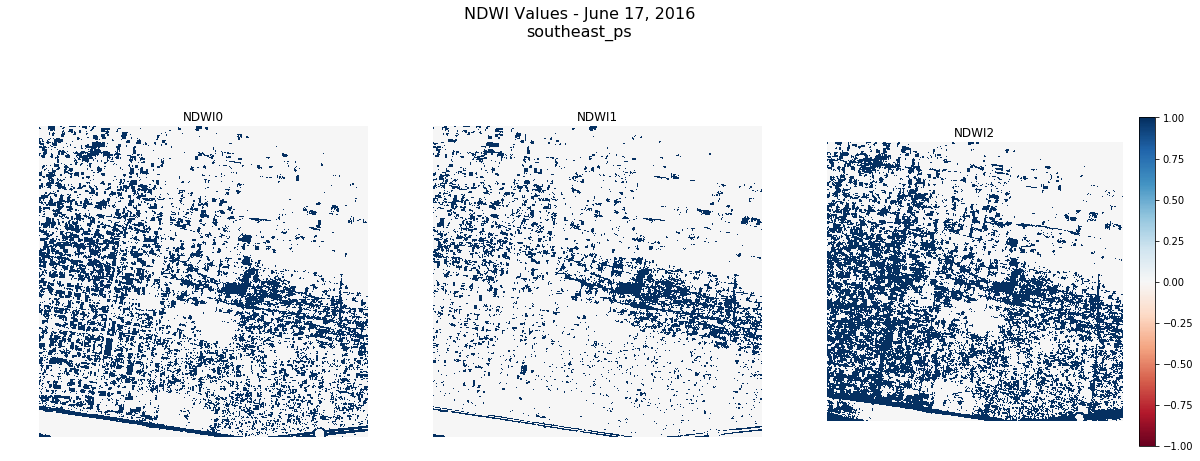

In [14]:
# Plot NDWIs for comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
threshold=-0.20
plt.suptitle('NDWI Values - June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi0_plot = ax1.imshow(ndwi0>threshold, cmap='RdBu',vmin=-1, vmax=1)
fig.colorbar(ndwi0_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_plot = ax2.imshow(ndwi1>threshold, cmap='RdBu',vmin=-1, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_plot = ax3.imshow(ndwi2>threshold, cmap='RdBu',vmin=-1, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

In [15]:
# Plot NDVI
# fig, ax = plt.subplots(figsize=(20,10))
# ndvi_plot = ax.imshow(ndvi, cmap='PiYG',
#                 vmin=-1, vmax=1)
# fig.colorbar(ndvi_plot, fraction=.05)
# ax.set(title="NDVI, June 17, 2016 \n" +aoi)
# ax.set_axis_off()
# plt.show()

In [16]:
# # Plot histogram to explore scaled value distribution 
# fig,ax = plt.subplots()
# plt.hist(dark.ravel());

In [17]:
# #Plot DARK parameter
# fig, ax = plt.subplots(figsize=(20,10))
# dark_plot = ax.imshow(dark, cmap='Spectral',
#                 vmin=0, vmax=3)
# fig.colorbar(dark_plot, fraction=.05)
# ax.set(title="DARK Parameter, June 17, 2016, \n"+aoi)
# ax.set_axis_off()
# plt.show()

# Calculate and apply cloud mask

### Users may change bands used and thresholds to define cloud mask. 

In [18]:
# Calculate and plot cloud mask
cloud_mask = calc_array_mask_test.define_mask(
    band1=coastal_scaled, band2=rededge_scaled, threshold1=0.25, threshold2=0.25, disk_size=15)

# Plot cloud mask
# fig, ax = plt.subplots(figsize=(12, 8))
# im = ax.imshow(cloud_mask,
#                cmap=plt.cm.get_cmap('tab20b', 2))
# cbar = fig.colorbar(im)
# cbar.set_ticks((0.25, .75))
# cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])
# ax.set_title("Cloud Mask | Light Purple Pixels will be Masked")
# ax.set_axis_off()
# plt.show()

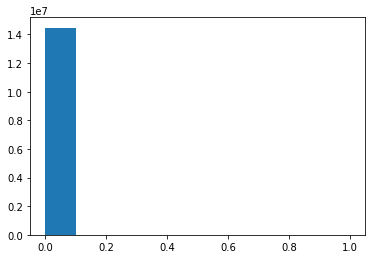

In [19]:
cloud_mask
fig,ax = plt.subplots()
plt.hist(cloud_mask.ravel());

In [20]:
# Apply cloud mask to scaled raster stack
all_bands_cl_free = calc_array_mask_test.apply_mask(mask_array = cloud_mask, raster_input = all_bands_scaled)
all_bands_cl_free_filled = ma.filled(all_bands_cl_free, fill_value=0)
# Write out cloud mask stack
# all_bands_cl_free_path = os.path.join(outputs_path, aoi + "_all_bands_cl_free.tif")
# all_bands_clfree, all_bands_cl_free_meta = es.stack(all_bands_cl_free,all_bands_cl_free_path)

In [21]:
with rio.open(outputs_path+'all_bands_cl_free_'+aoi+'.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_cl_free)
with rio.open(outputs_path+'all_bands_cl_free_filled'+aoi+'.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_cl_free_filled)

In [22]:
# Define cloud masked scaled bands
coastal_cl_free = all_bands_cl_free[0]
blue_cl_free = all_bands_cl_free[1]
green_cl_free = all_bands_cl_free[2]
yellow_cl_free = all_bands_cl_free[3]
red_cl_free = all_bands_cl_free[4]
rededge_cl_free = all_bands_cl_free[5]
nearir1_cl_free = all_bands_cl_free[6]
nearir2_cl_free = all_bands_cl_free[7]

In [23]:
# for testing gbdx code..
with rio.open(outputs_path+'coastal_cl_free_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(coastal_cl_free,1)

In [24]:
# Calculated NDWI, NDVI and dark parameter for cloud masked bands
ndwi0_cl_free = es.normalized_diff(b1=green_cl_free, b2=nearir1_cl_free)  
ndwi1_cl_free = es.normalized_diff(b1=coastal_cl_free, b2=nearir2_cl_free)
ndwi2_cl_free = es.normalized_diff(b1= yellow_cl_free, b2=nearir2_cl_free)
ndvi_cl_free = es.normalized_diff(b1=nearir1_cl_free, b2= red_cl_free)
dark_cl_free = rededge_cl_free+nearir1_cl_free+nearir2_cl_free

In [25]:
# Calc mud and soil indices


In [26]:
# Compare mean NDWI valuespre and post cloud mask
mean_ndwi0_cl_free = np.nanmean(ndwi0_cl_free)
mean_ndwi1_cl_free = np.nanmean(ndwi1_cl_free)
mean_ndwi2_cl_free = np.nanmean(ndwi2_cl_free)

print("NDWI0_cl_free:",mean_ndwi0_cl_free, "NDWI1_cl_free:", mean_ndwi1_cl_free, "NDWI2_cl_free:", mean_ndwi2_cl_free)
print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0_cl_free: -0.3205028 NDWI1_cl_free: -0.4359572 NDWI2_cl_free: -0.2937154
NDWI0: -0.320346 NDWI1: -0.4357712 NDWI2: -0.29354703


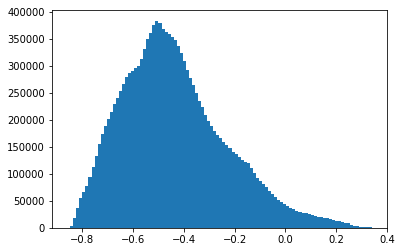

In [27]:
# Plot histogram to explore distribution of NDWI values
fig,ax = plt.subplots()
plt.hist(ndwi1_cl_free.ravel(),bins=100);

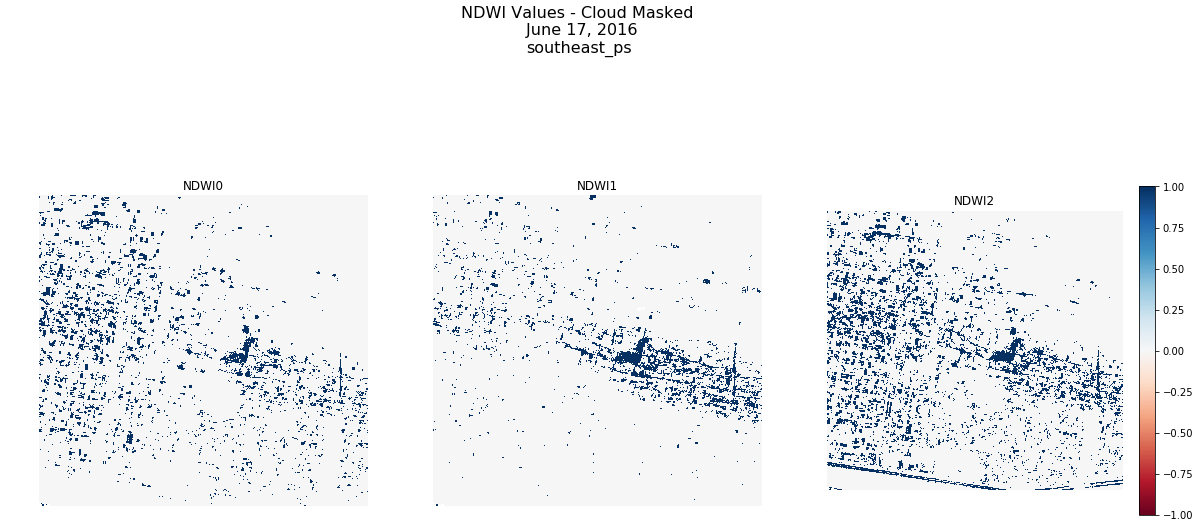

In [28]:
# Plot NDWIs for cloud masked
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
threshold=-0.05
plt.suptitle('NDWI Values - Cloud Masked \n June 17, 2016\n'+aoi, fontsize=16)

ndwi0_cl_free_plot = ax1.imshow(ndwi0_cl_free>threshold, cmap='RdBu',vmin=-1, vmax=1)
fig.colorbar(ndwi0_cl_free_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_cl_free_plot = ax2.imshow(ndwi1_cl_free>threshold, cmap='RdBu',vmin=-1, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_cl_free_plot = ax3.imshow(ndwi2_cl_free>threshold, cmap='RdBu',vmin=-1, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

In [29]:
# # Plot cloud masked NDVI parameter
# fig, ax = plt.subplots(figsize=(20,10))
# ndvi_cl_free_plot = ax.imshow(ndvi_cl_free, cmap='PiYG',
#                 vmin=-1, vmax=0.9)
# fig.colorbar(ndvi_cl_free_plot, fraction=.05)
# ax.set(title="NDVI - Cloud Masked \n June 17, 2016\n"+aoi)
# ax.set_axis_off()
# plt.show()

In [30]:
# # Plot cloud masked DARK parameter
# fig, ax = plt.subplots(figsize=(20,10))
# dark_cl_free_plot = ax.imshow(dark_cl_free, cmap='Spectral',
#                 vmin=0, vmax=2.5)
# fig.colorbar(dark_cl_free_plot, fraction=.05)
# ax.set(title="DARK Parameter - Cloud Masked \n June 17, 2016\n"+aoi)
# ax.set_axis_off()
# plt.show()

In [31]:
# Write out tif files for ndwi, ndvi, dark parameters
# with rio.open(outputs_path+'ndwi0_'+aoi+'.tif', 'w', **files_out_meta) as dst:
#     dst.write(ndwi0_cl_free, 1)
# with rio.open(outputs_path+'ndwi1_'+aoi+'.tif', 'w', **files_out_meta) as dst:
#     dst.write(ndwi1_cl_free, 1)
# with rio.open(outputs_path+'ndwi2_'+aoi+'.tif', 'w', **files_out_meta) as dst:
#     dst.write(ndwi2_cl_free, 1)
# with rio.open(outputs_path+'ndvi_'+aoi+'.tif', 'w', **files_out_meta) as dst:
#     dst.write(ndvi_cl_free, 1)
# with rio.open(outputs_path+'dark_'+aoi+'.tif', 'w', **files_out_meta) as dst:
#     dst.write(dark_cl_free, 1)
    
with rio.open(outputs_path+'ndwi0.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi0_cl_free, 1)
with rio.open(outputs_path+'ndwi1.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi1_cl_free, 1)
with rio.open(outputs_path+'ndwi2.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi2_cl_free, 1)
with rio.open(outputs_path+'ndvi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndvi_cl_free, 1)
with rio.open(outputs_path+'raw_dark.tif', 'w', **files_out_meta) as dst:
    dst.write(dark_cl_free, 1)

In [32]:
with rio.open(outputs_path+'raw_rededge.tif', 'w', **files_out_meta) as dst:
    dst.write(rededge_cl_free, 1)
with rio.open(outputs_path+'raw_nearir1.tif', 'w', **files_out_meta) as dst:
    dst.write(nearir1_cl_free, 1)
with rio.open(outputs_path+'raw_nearir2.tif', 'w', **files_out_meta) as dst:
    dst.write(nearir2_cl_free, 1)

In [33]:
print(ndwi1_cl_free.min(), ndwi1_cl_free.max())
print(dark_cl_free.min(), dark_cl_free.max())
print(coastal_cl_free.min(), coastal_cl_free.max())
print(red_cl_free.min(), red_cl_free.max())

-0.85878634 0.33935013
0.0089 3.9889002
0.0014 0.9572
0.0021 1.1283


## Note that these parameters are different than before to see if more flood can be identified using different thresholds

### The threshold values for each flood mask can be changed per user preferences

In [34]:
# Calculate parameters for Cloud to Street algorithm
# Flood1 mask is for NDWI1 and Flood2 mask is for NDWI2
# Change ndwi1_cl_free threshold to -0.05 instead of -0.35
# Original thresholds - Dark <=3, coastal and red <=1 (?)
flood1_cl_free = ((ndwi1_cl_free >= -0.30) & (dark_cl_free <= 2) & (coastal_cl_free <= 0.5) & (red_cl_free <= 0.5)).astype(int)
flood2_cl_free = ((ndwi2_cl_free >= -0.12) & (dark_cl_free <= 2) & (coastal_cl_free <= 0.5)).astype(int)
# Combine flood1 and flood 2
flood_combo = np.ma.where(flood1_cl_free==1, 1, np.where(flood2_cl_free==1,1, 0))

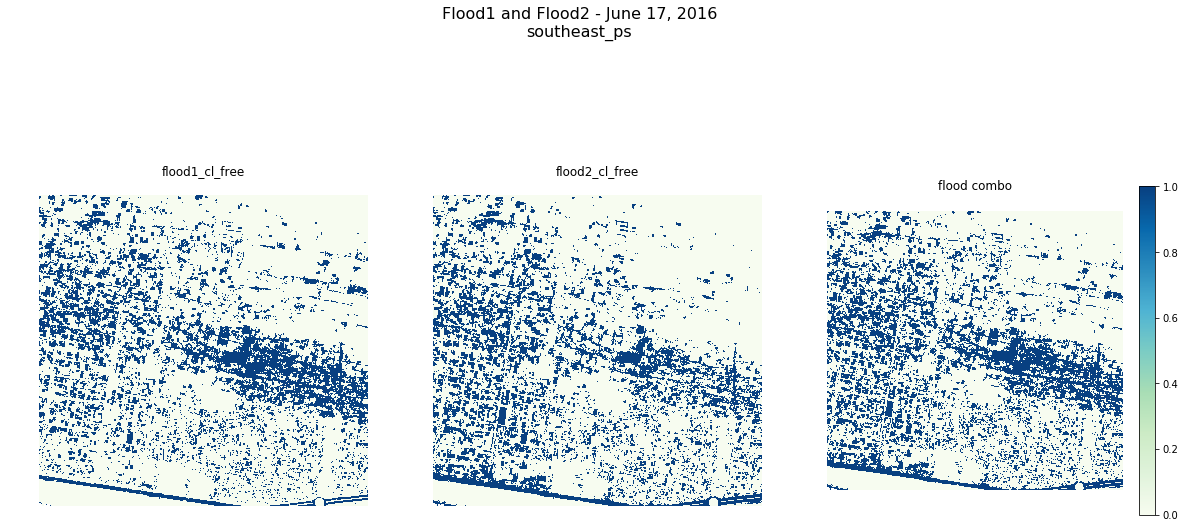

In [35]:
#Plot Flood1, Flood2 and Flood Combo masks
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
plt.suptitle('Flood1 and Flood2 - June 17, 2016\n'+aoi+"\n", fontsize=16)

flood1_cl_free_plot = ax1.imshow(flood1_cl_free, cmap='GnBu',vmin=0, vmax=1)
fig.colorbar(flood1_cl_free_plot, fraction=.05)
ax1.set(title="flood1_cl_free\n")
ax1.set_axis_off()


flood2_cl_free_plot = ax2.imshow(flood2_cl_free, cmap='GnBu',vmin=0, vmax=1)
ax2.set(title="flood2_cl_free\n")
ax2.set_axis_off() 

flood_combo_plot = ax3.imshow(flood_combo, cmap='GnBu',vmin=0, vmax=1)
ax3.set(title="flood combo\n")
ax3.set_axis_off() 

### The threshold values for each NDWI mask can be changed per user preferences

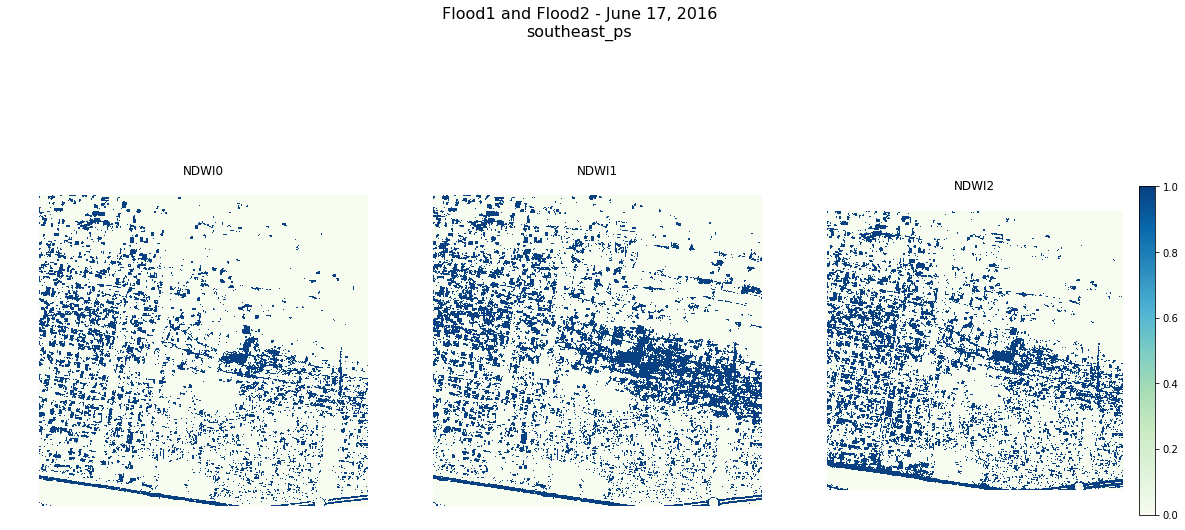

In [36]:
#Plot NDWI masks

ndwi0_thresh = -0.12
ndwi1_thresh = -0.30
ndwi2_thresh = -0.12

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('Flood1 and Flood2 - June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi0 = ax1.imshow(ndwi0_cl_free>ndwi0_thresh, cmap='GnBu',vmin=0, vmax=1)
fig.colorbar(flood1_cl_free_plot, fraction=.05)
ax1.set(title="NDWI0\n")
ax1.set_axis_off()

ndwi1 = ax2.imshow(ndwi1_cl_free>ndwi1_thresh, cmap='GnBu',vmin=0, vmax=1)
ax2.set(title="NDWI1\n")
ax2.set_axis_off() 

ndwi2 = ax3.imshow(ndwi2_cl_free>ndwi2_thresh, cmap='GnBu',vmin=0, vmax=1)
ax3.set(title="NDWI2\n")
ax3.set_axis_off() 

### User can make choices on threshold and disk_size for morphological smoothing

In [37]:
# Apply morphological opening to reduce noise for flood combo
flood_mask = morph_indices.smooth_disk(index_array = flood_combo, threshold=0.1,disk_size=1)
ndwi1_mask = morph_indices.smooth_disk(index_array = ndwi1_cl_free, threshold=-0.1,disk_size=1)

# Develop vegetation mask with noise removed for NDVI  
vegetation_mask = morph_indices.smooth_disk(index_array = ndvi_cl_free,threshold=0.1,disk_size=0)

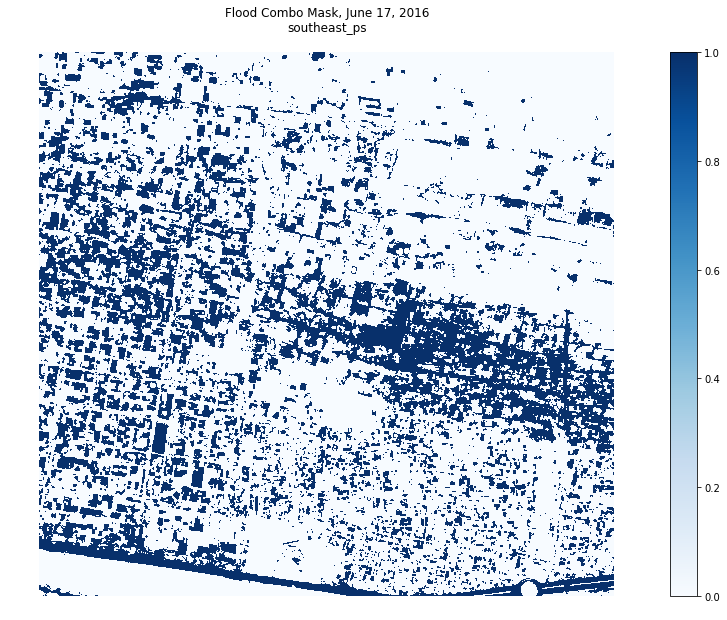

In [38]:
# # Plot flood combo mask with noise morphologically removed 
fig, ax = plt.subplots(figsize=(20,10))
flood_opened_plot = ax.imshow(flood_mask, cmap='Blues',
                vmin=0, vmax=1)
fig.colorbar(flood_opened_plot, fraction=.05)
ax.set(title="Flood Combo Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

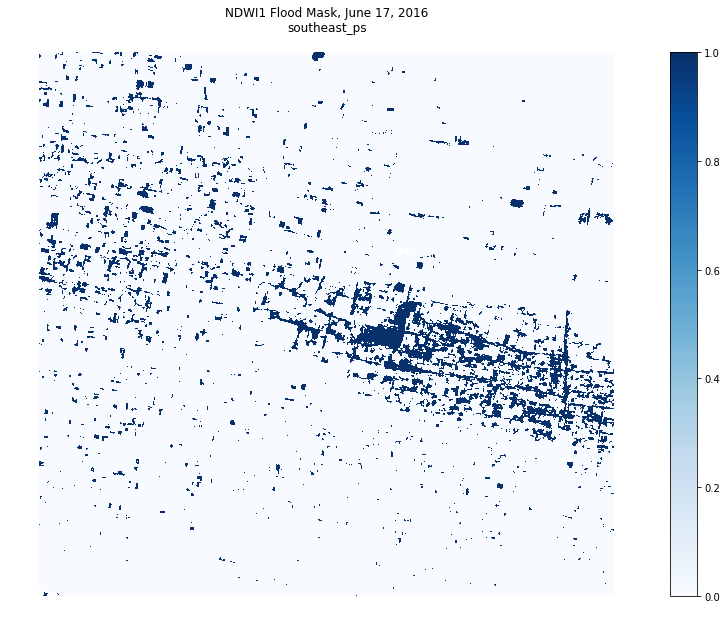

In [39]:
# # Plot NDWI1 flood mask with noise morphologically removed 
fig, ax = plt.subplots(figsize=(20,10))
flood_opened_plot = ax.imshow(ndwi1_mask, cmap='Blues',
                vmin=0, vmax=1)
fig.colorbar(flood_opened_plot, fraction=.05)
ax.set(title="NDWI1 Flood Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

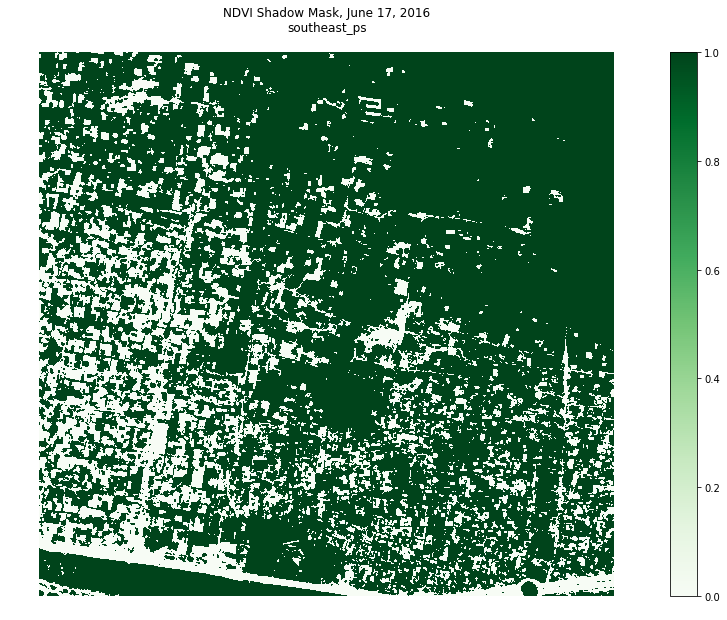

In [40]:
# Plot vegetation mask 
fig, ax = plt.subplots(figsize=(20,10))
test_plot = ax.imshow(vegetation_mask, cmap='Greens',
                vmin=0, vmax=1)
fig.colorbar(test_plot, fraction=.05)
ax.set(title="NDVI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [41]:
# Write out flood mask files
with rio.open(outputs_path+'flood1_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood1_cl_free, 1)
with rio.open(outputs_path+'flood2_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood2_cl_free, 1)
with rio.open(outputs_path+'flood_combo_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood_mask, 1)
    
# Write out vegetation mask file
with rio.open(outputs_path+'vegetation_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(vegetation_mask, 1)

In [42]:
#Write out mask files based on thresholds
with rio.open(outputs_path+'ndwi0_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi0_cl_free>-0.12).astype(int), 1)
with rio.open(outputs_path+'ndwi1_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi1_cl_free>-0.12).astype(int), 1)
with rio.open(outputs_path+'ndwi2_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi2_cl_free>-0.12).astype(int), 1)
# with rio.open(outputs_path+'ndvi_mask_'+'.tif', 'w', **masks_out_meta) as dst:
#     dst.write((ndvi_cl_free>0.1).astype(int), 1)

### User can change s_min, s_max and s_delta. Current parameters chosen based on Huang et al. (2012)

## Using cloud masked stack results in a masked MSI

In [43]:
# Calculate MSI with cloud masked stack
msi = morph_indices.calc_msi(raster_input=all_bands_cl_free, s_min=2, s_max=52, s_delta = 5)
# print(msi.max())

In [44]:
# # Calculate MSI using scaled bands (no cloud mask)
# msi = morph_indices.calc_msi(raster_input=all_bands_scaled, s_min=2, s_max=52, s_delta = 5)

In [45]:
# def calc_msi(raster_input, s_min, s_max, s_delta):

#     """ Calculates morphological shadow index (MSI) per Huang et al. (2015)
#     Assumes use of linear structuring element
#     MSI = sum(dxs)(blacktop_hat(morphological profiles))/(D*S)
#     d = degrees (0,45, 90, 135)
#     D = 4
#     s = size of linear structuring element (pixels)
#     S = (s_max-s_min)/s_delta + 1

#     Parameters
#     ------------
#     raster_input : 3-dim raster (tif) stack for calculating brightness
#     s_min, s_max, s_delta: numerical input (integer)

#     Returns
#     ------------
#     Calculated values for MSI in a numpy array
#     """
#     import numpy as np
#     import numpy.ma as ma
#     from skimage.morphology import black_tophat
#     from skimage import draw

#     # # Function for calculating the linear structuring element
#     # def selemline(length, theta, dtype=np.uint8):
#     #     """Line structuring element"""
#     #     theta_d = theta * np.pi / 180
#     #     X = int(round((length-1)/2. * np.cos(theta_d)))
#     #     Y = int(-round((length-1)/2. * np.sin(theta_d)))
#     #     C, R, V = draw.line_aa(-X, -Y, X, Y)
#     #     M = 2*max(abs(R)) + 1
#     #     N = 2*max(abs(C)) + 1
#     #     selem = np.zeros((M, N)).astype(dtype)
#     #     selem[R + max(abs(R)), C + max(abs(C))] = 1
#     #     return selem


# # Calculate brightness for cloud masked stack
# brightness=np.nanmax(all_bands_cl_free, axis=0)

# # Cap brightness values at a max of 1. Replace all values greater than 1 with a value of 1
# brightness_cap=np.ma.where(brightness>1,1,brightness)

# # Initialize inputs for MSI calculation
# selem = selemline(0,0)
# b_tophat_array_sum = black_tophat(brightness_cap, selem)

# #     # Loop and sum black tophat morphological profiles for MSI calculation
# #     for i in range(s_min,s_max+s_delta,s_delta):
# #         for x in range(0, 4):
# #             selem = selemline(i,45*x)
# #             b_tophat = black_tophat(brightness_cap,selem)
# #             b_tophat_array_sum = b_tophat_array_sum.__add__(b_tophat)

# #     D = 4
# #     S = ((s_max-s_min)/s_delta) + 1
# #     msi = b_tophat_array_sum/(D*S)

# #     return msi


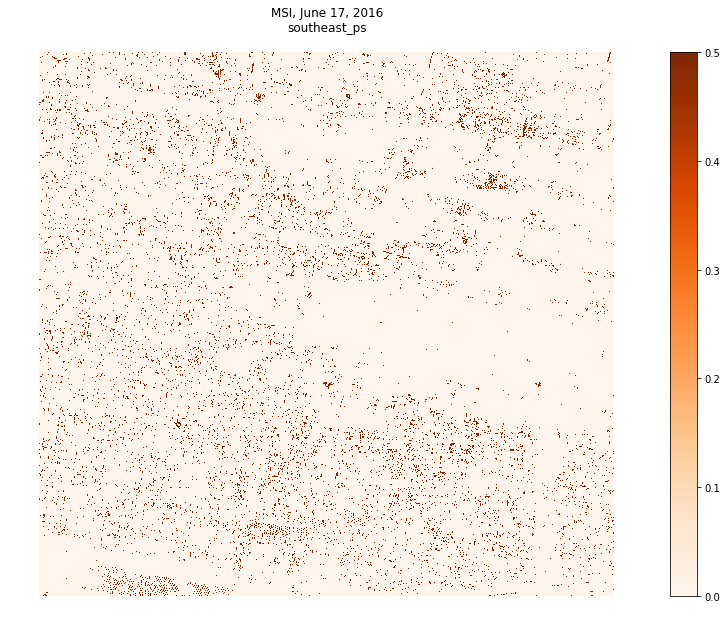

In [46]:
# Plot MSI
fig, ax = plt.subplots(figsize=(20,10))
msi_plot = ax.imshow(msi>=0.12, cmap='Oranges',
                vmin=0, vmax=0.5)
fig.colorbar(msi_plot, fraction=0.05)
ax.set(title="MSI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

### *Think about how to handle cloud edge effects. Large max MSI indicates a potential issue*

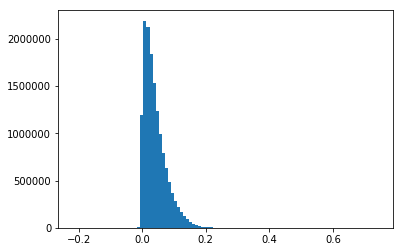

In [47]:
# Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(msi.ravel(),bins=100);

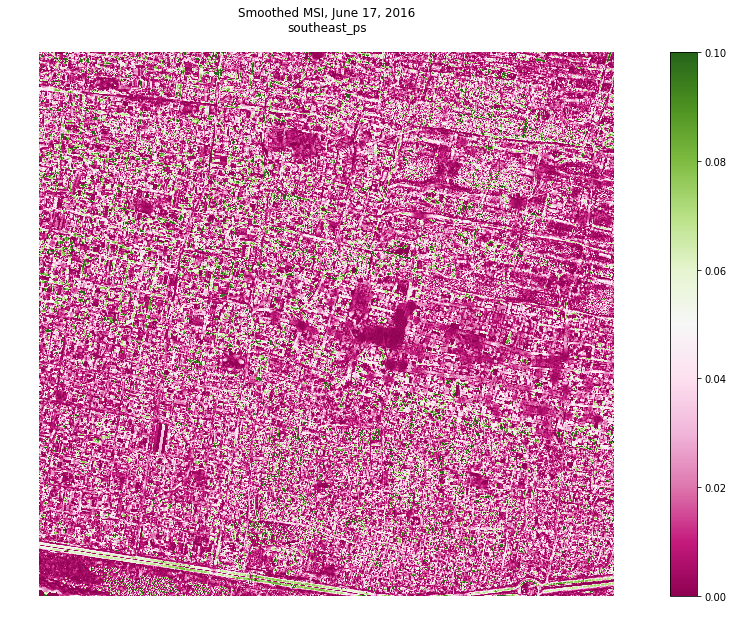

In [48]:
# Test to visualize effects of smoothing MSI to reduce noise/small areas of shadow
from skimage.morphology import opening, disk
selem_msi = disk(3)
smoothed_msi = opening(msi, selem_msi)

# Plot shadow mask 
fig, ax = plt.subplots(figsize=(20,10))
test_plot = ax.imshow(smoothed_msi, cmap='PiYG',
                vmin=0, vmax=0.1)
fig.colorbar(test_plot, fraction=.05)
ax.set(title="Smoothed MSI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

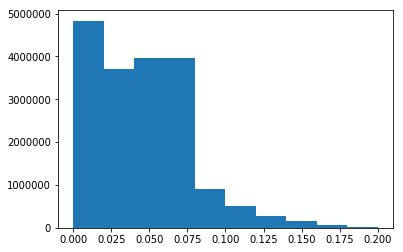

In [49]:
# Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(msi.ravel(),bins=[0,0.02,0.04,0.08,0.10,0.12,0.14,0.16,0.18,0.20]);

Initial mask was threshold = 0.12 and size = 2
v2 was threshold = 0.10 and size = 2
v3 was threshold 0.10 and size 3 (was this 2?)
v4 was threshold 0.08 and size 3
test is threshold 0.11 and size=2
naming convention for changes to msi is now shadow_mask_010, 012, etc. 

In [50]:
# Develop shadow mask from MSI. Threshold and disk size may be varied. 
shadow_mask = morph_indices.smooth_disk(index_array=msi,threshold=0.12,disk_size=2)

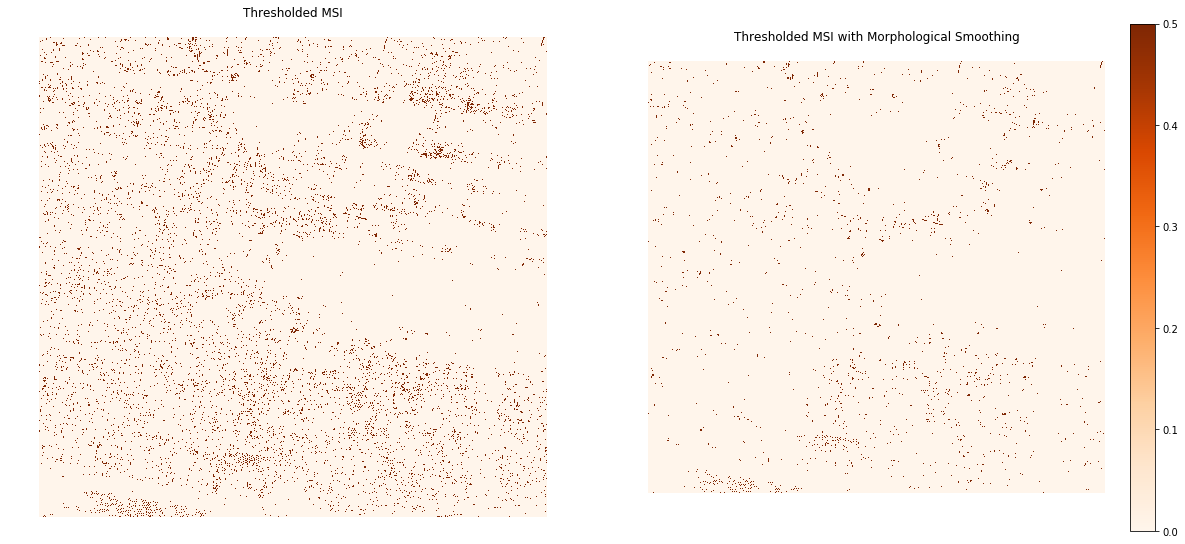

In [51]:
# Plot denoised shadow mask using morphological smoothing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


msi_plot = ax1.imshow(msi>=0.12, cmap = 'Oranges', vmin = 0, vmax = 0.5)
ax1.set(title="Thresholded MSI\n")
ax1.set_axis_off()

morph_plot = ax2.imshow(shadow_mask, cmap = 'Oranges', vmin = 0, vmax = 0.5)
ax2.set(title="Thresholded MSI with Morphological Smoothing\n")
ax2.set_axis_off()

fig.colorbar(msi_plot, fraction=.05)
plt.show()

# Write out denoised morphologically opened raster


## Experimentation with measure.label
Causes issues as makes it so that mask is no longer a mask.
Try instead with msi as an input and then make into a mask - doesn't work as msi values are not exactly the same, so no labels are formed.

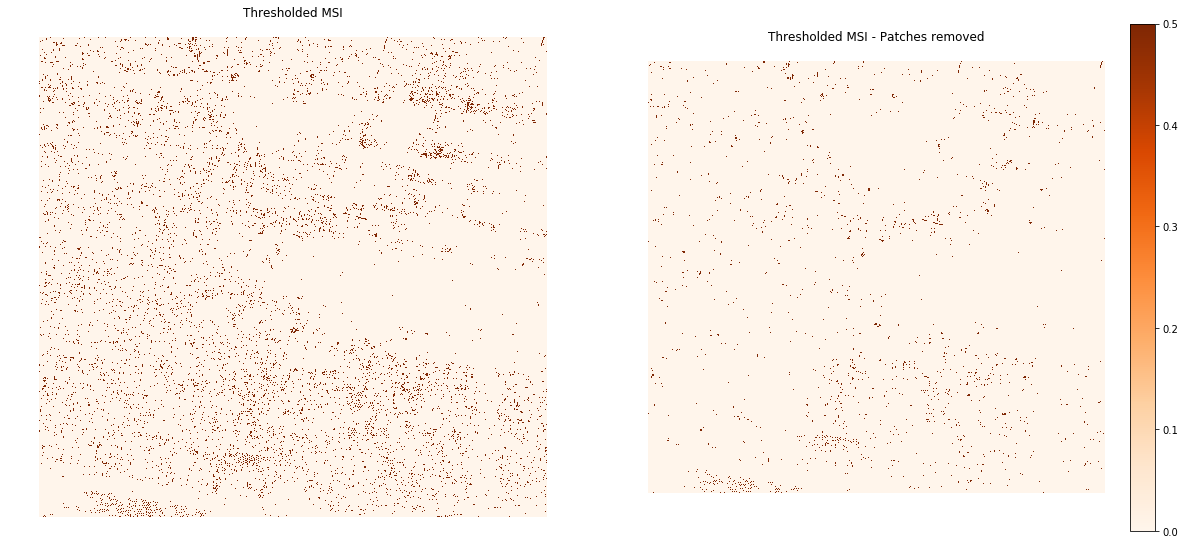

In [52]:
# Use remove small patches function
shadow_mask_patches = morph_indices.remove_small_patches(shadow_mask,10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


msi_plot = ax1.imshow(msi>=0.12, cmap = 'Oranges', vmin = 0, vmax = 0.5)
ax1.set(title="Thresholded MSI\n")
ax1.set_axis_off()

morph_plot = ax2.imshow(shadow_mask_patches, cmap = 'Oranges', vmin = 0, vmax = 0.5)
ax2.set(title="Thresholded MSI - Patches removed\n")
ax2.set_axis_off()

fig.colorbar(msi_plot, fraction=.05)
plt.show()

In [53]:
with rio.open(outputs_path+'threshold_msi.tif', 'w', **files_out_meta) as dst:
    dst.write((msi>=0.12).astype('float32'), 1)
with rio.open(outputs_path+'shadow_mask_patches_removed.tif', 'w', **files_out_meta) as dst:
    dst.write(shadow_mask_patches.astype('float32'), 1)

In [54]:
# from skimage import measure
# from skimage import morphology

# patch_labels = measure.label(shadow_mask) 

# # Remove all small objects less than a certain size
# shadow_mask_cleaned = morphology.remove_small_objects(patch_labels, min_size=10)
# # Plot flood mask layer 
# fig, ax = plt.subplots(figsize=(20,10))
# shadow_mask_cleaned_plot = ax.imshow(shadow_mask_cleaned, cmap='Oranges',
#                 vmin=0, vmax=0.1)
# fig.colorbar(shadow_mask_cleaned_plot, fraction=.05)
# ax.set(title="Shadow Mask - Small Objects Removed, June 17, 2016\n"+aoi+"\n")
# ax.set_axis_off()
# plt.show()

De-noising methods appeared to produce similar results. For final workflow, selected to use morphological smoothing. 

## Apply shadow mask to stack - trying new fill value (and for cloud mask too)

In [55]:
# Apply shadow mask to scaled band stack
all_bands_shadow_free = calc_array_mask_test.apply_mask(mask_array = shadow_mask, raster_input = all_bands_cl_free)
all_bands_shadow_free_filled = ma.filled(all_bands_shadow_free, fill_value=0)

In [56]:
# Write out shadow masked stack
# print(all_bands_shadow_free.shape)
# print(stack_out_meta)
# test=all_bands_shadow_free.filled()
# test=all_bands_shadow_free
# ma.set_fill_value(test, -99999)
with rio.open(outputs_path+'shadow_masked_stack.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_shadow_free)
with rio.open(outputs_path+'shadow_masked_stack_filled.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_shadow_free_filled)

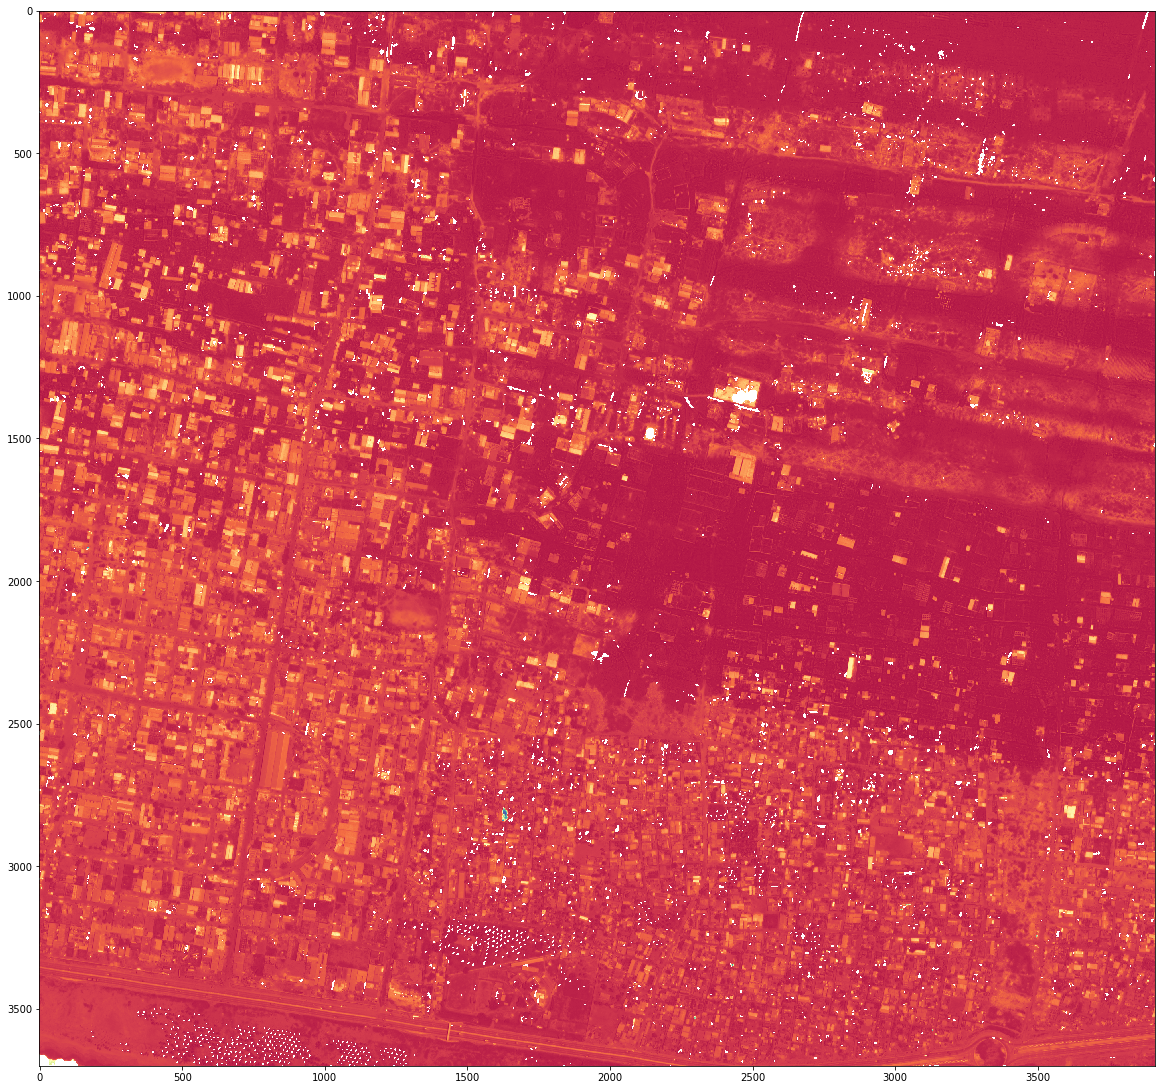

In [57]:
# brightness=np.max(all_bands_shadow_free, axis=0)
# brightness.min()
fig, ax = plt.subplots(figsize = (20,20))
plt.imshow(all_bands_shadow_free[0], cmap='Spectral')

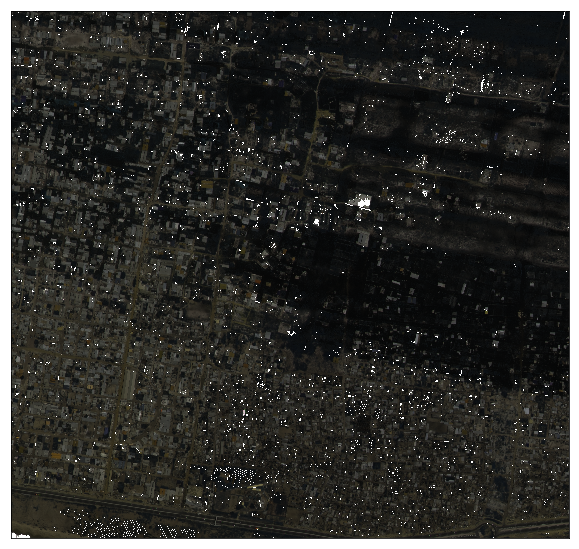

In [58]:
# Check to see if bands have been shadow masked
import earthpy.plot as ep
ep.plot_rgb(all_bands_shadow_free,rgb=(4,3,2))
ax.set_axis_off()

## Exploring building shadow masked NDWI values

In [59]:
# Define shadow masked scaled bands
coastal_shadow_free = all_bands_shadow_free[0]
blue_shadow_free = all_bands_shadow_free[1]
green_shadow_free = all_bands_shadow_free[2]
yellow_shadow_free = all_bands_shadow_free[3]
red_shadow_free = all_bands_shadow_free[4]
rededge_shadow_free = all_bands_shadow_free[5]
nearir1_shadow_free = all_bands_shadow_free[6]
nearir2_shadow_free = all_bands_shadow_free[7]

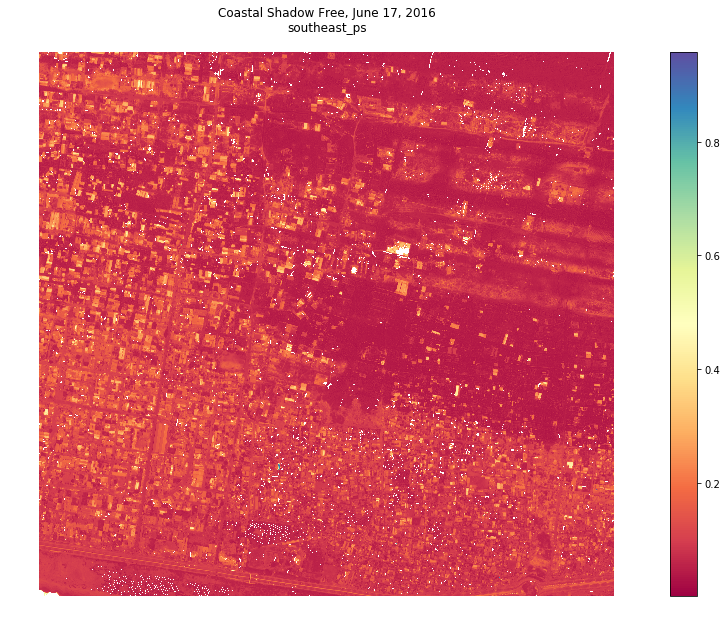

In [60]:
# Plot shadow mask 
fig, ax = plt.subplots(figsize=(20,10))
test_plot = ax.imshow(coastal_shadow_free, cmap='Spectral')
fig.colorbar(test_plot, fraction=.05)
ax.set(title="Coastal Shadow Free, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [61]:
# Calculate NDWI, NDVI and dark parameter for building shadow masked bands
ndwi0_shadow_free = es.normalized_diff(b1=green_shadow_free, b2=nearir1_shadow_free)  
ndwi1_shadow_free = es.normalized_diff(b1=coastal_shadow_free, b2=nearir2_shadow_free)
ndwi2_shadow_free = es.normalized_diff(b1= yellow_shadow_free, b2=nearir2_shadow_free)
ndvi_shadow_free = es.normalized_diff(b1=nearir1_shadow_free, b2= red_shadow_free)
dark_shadow_free = rededge_cl_free+nearir1_shadow_free+nearir2_shadow_free

In [62]:
# Compare mean NDWI values pre and post shadow mask
mean_ndwi0_shadow_free = np.nanmean(ndwi0_shadow_free)
mean_ndwi1_shadow_free = np.nanmean(ndwi1_shadow_free)
mean_ndwi2_shadow_free = np.nanmean(ndwi2_shadow_free)

print("NDWI0_shadow_free:",mean_ndwi0_shadow_free, "NDWI1_shadow_free:", mean_ndwi1_shadow_free, "NDWI2_shadow_free:", mean_ndwi2_shadow_free)
print("NDWI0_cl_free:",mean_ndwi0_cl_free, "NDWI1_cl_free:", mean_ndwi1_cl_free, "NDWI2_cl_free:", mean_ndwi2_cl_free)
print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0_shadow_free: -0.32069385 NDWI1_shadow_free: -0.43639496 NDWI2_shadow_free: -0.29383513
NDWI0_cl_free: -0.3205028 NDWI1_cl_free: -0.4359572 NDWI2_cl_free: -0.2937154
NDWI0: -0.320346 NDWI1: -0.4357712 NDWI2: -0.29354703


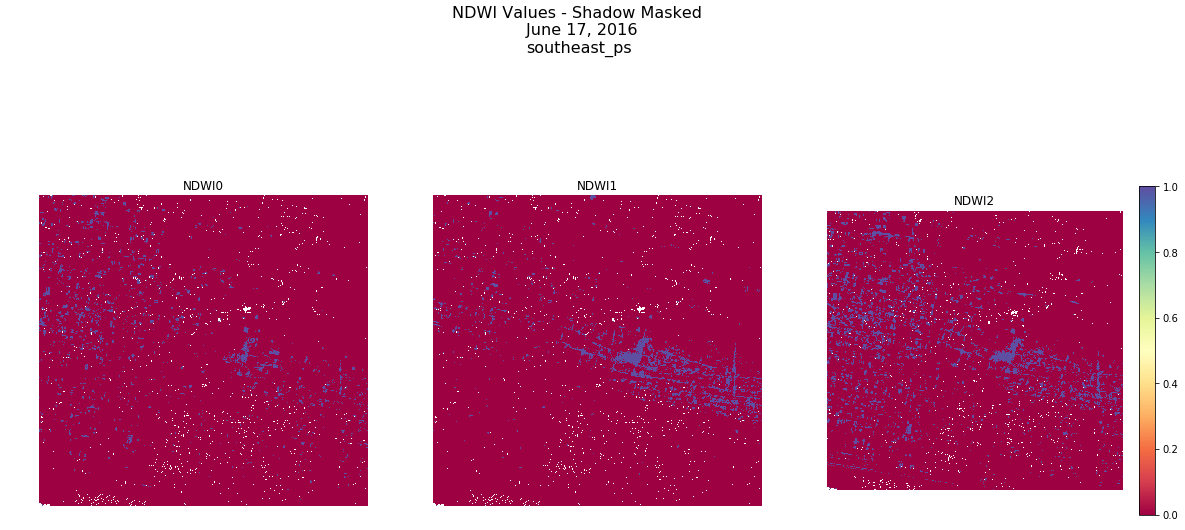

In [63]:
# Plot NDWIs masks for shadow masked
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
threshold = 0

plt.suptitle('NDWI Values - Shadow Masked \n June 17, 2016\n'+aoi, fontsize=16)

ndwi0_shadow_free_plot = ax1.imshow(ndwi0_shadow_free>=threshold, cmap='Spectral',vmin=0, vmax=1)
fig.colorbar(ndwi0_shadow_free_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_shadow_free_plot = ax2.imshow(ndwi1_shadow_free>=threshold, cmap='Spectral',vmin=0, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_shadow_free_plot = ax3.imshow(ndwi2_shadow_free>=threshold, cmap='Spectral',vmin=0, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

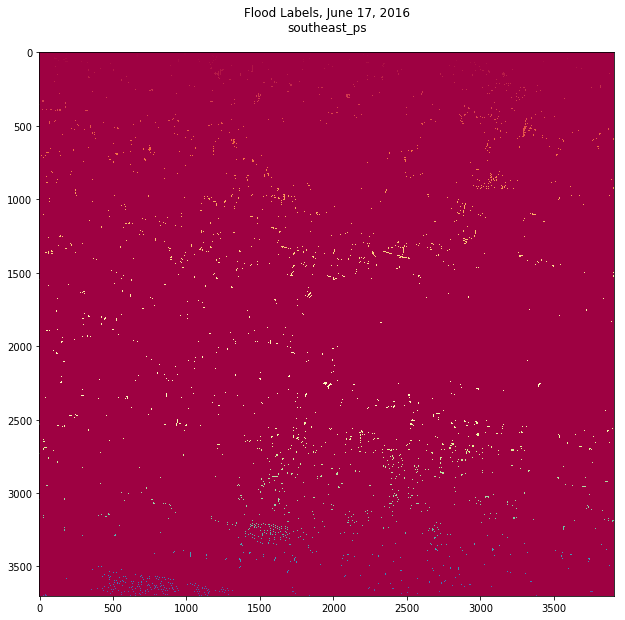

In [64]:
# Experimentation with labeling shadow mask
from skimage import measure
from skimage import morphology

patch_labels = measure.label(shadow_mask, background=0) 
props = measure.regionprops(patch_labels) 
# patchsize_thresh = 30
small_patches = []
for prop in props:
    if prop.area < 2:
        small_patches.append(prop.label)
len(small_patches)

# Remove all small objects less than a certain size
# flood_cleaned = morphology.remove_small_objects(patch_labels, min_size=500)

# Plot flood label layer 
fig, ax = plt.subplots(figsize=(20,10))
flood_cleaned_plot = ax.imshow(patch_labels, cmap='Spectral')
ax.set(title="Flood Labels, June 17, 2016\n"+aoi+"\n")
# ax.set_axis_off()
plt.show()

In [65]:
# Write out MSI and shadow mask tif file
with rio.open(outputs_path+'shadow_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(shadow_mask, 1)
with rio.open(outputs_path+'msi'+'.tif', 'w', **files_out_meta) as dst:
    dst.write(msi, 1)
with rio.open(outputs_path+'raw_msi'+'.tif', 'w', **files_out_meta) as dst:
    dst.write(msi, 1)
# with rio.open(outputs_path+'msi_smoothed_'+aoi+'.tif', 'w', **files_out_meta) as dst:
#     dst.write(smoothed_msi, 1)

In [66]:
# Write out shadow masked NDWI, NDVI and DARK parameter files
with rio.open(outputs_path+'ndwi0_shadow_mask.tif', 'w', **files_out_meta_test) as dst:
    dst.write(ndwi0_shadow_free, 1)
with rio.open(outputs_path+'ndwi1_shadow_mask.tif', 'w', **files_out_meta_test) as dst:
    dst.write(ndwi1_shadow_free, 1)
with rio.open(outputs_path+'ndwi2_shadow_mask.tif', 'w', **files_out_meta_test) as dst:
    dst.write(ndwi2_shadow_free, 1)
with rio.open(outputs_path+'ndvi_shadow_mask.tif', 'w', **files_out_meta_test) as dst:
    dst.write(ndvi_shadow_free, 1)
with rio.open(outputs_path+'dark_shadow_mask.tif', 'w', **files_out_meta_test) as dst:
    dst.write(dark_shadow_free, 1)

# Plot Shadow, Flood and Vegetation Masks

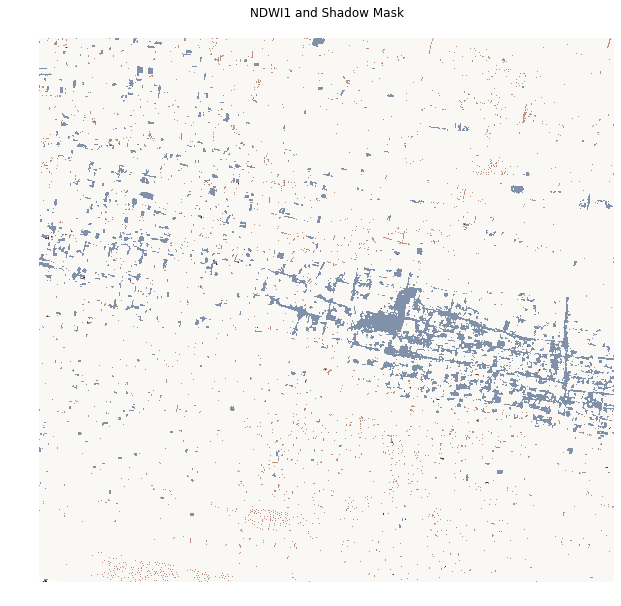

In [67]:
# Compare plots for various flood masks and shadow mask
fig, ax1 = plt.subplots(figsize=(20, 10))

# plt.suptitle('NDWI1, NDWI2, Flood Combo and MSI Shadow Mask - June 17, 2016\n'+aoi, fontsize=16)

ndwi1_plot = ax1.imshow(ndwi1_cl_free>=-0.05, cmap = 'Blues', vmin = 0, vmax = 1)
msi_plot = ax1.imshow(shadow_mask>=0.12, cmap='Oranges', vmin = 0.00, vmax = 0.1, alpha = .5)
ax1.set(title="NDWI1 and Shadow Mask\n")
ax1.set_axis_off()

# ndwi2_plot = ax2.imshow(ndwi2_cl_free>=0.03, cmap = 'Blues', vmin = 0, vmax = 1)
# msi_plot = ax2.imshow(shadow_mask>=0.12, cmap='Oranges', vmin = 0.00, vmax = 0.1, alpha = .5)
# ax2.set(title="NDWI2 and Shadow Mask\n")
# ax2.set_axis_off() 

# flood_combo_plot = ax3.imshow(flood_combo>=1, cmap = 'Blues', vmin = 0, vmax = 1)
# msi_plot = ax3.imshow(shadow_mask>=0.12, cmap='Oranges', vmin = 0.00, vmax = 0.1, alpha = .5)
# ax3.set(title="Flood Combo and Shadow Mask\n")
# ax3.set_axis_off()

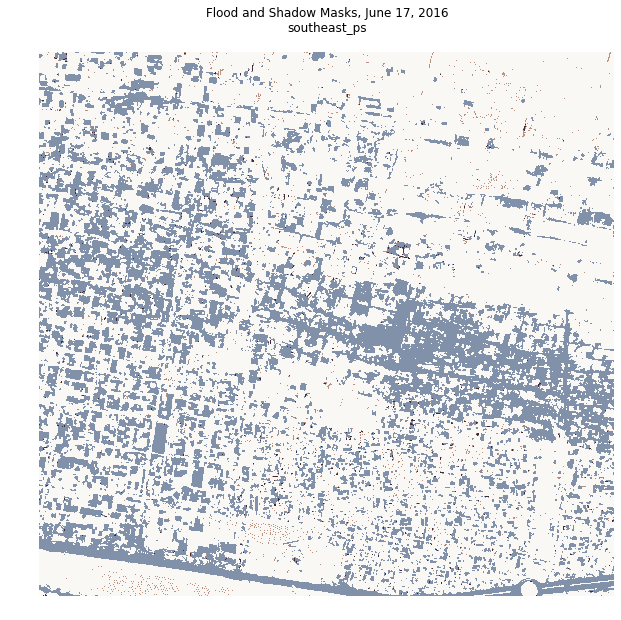

In [68]:
# Plot flood and shadow masks
fig, ax = plt.subplots(figsize=(20,10))
flood_plot = ax.imshow(flood_mask==1, cmap = 'Blues', vmin = 0, vmax = 1)
shadow_plot = ax.imshow(shadow_mask==1, cmap='Oranges', vmin = 0.00, vmax = 1, alpha = .5)

ax.set(title="Flood and Shadow Masks, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

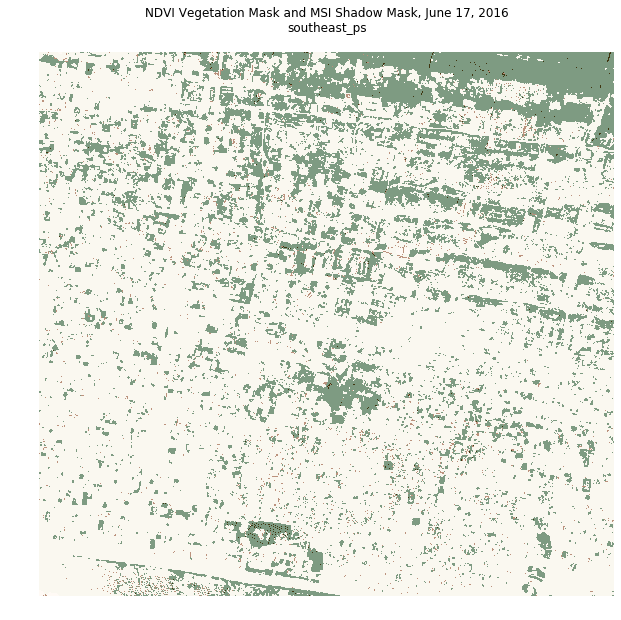

In [69]:
# Plot vegetation and shadow masks
fig, ax = plt.subplots(figsize=(20,10))
ndvi_plot = ax.imshow(ndvi_cl_free>.5, cmap = 'Greens')
msi_plot = ax.imshow(shadow_mask>=1, cmap='Oranges',alpha = .5)

ax.set(title="NDVI Vegetation Mask and MSI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

# Calculate NDWI "optimal" - MSI from Xie et al (2016)

In [70]:
# Calculate optimal NDWI values with NIR2
ndwi_coastal = es.normalized_diff(b1=coastal_cl_free, b2 = nearir2_cl_free)
ndwi_green = es.normalized_diff(b1=green_cl_free, b2 = nearir2_cl_free)
ndwi_blue = es.normalized_diff(b1=blue_cl_free, b2 = nearir2_cl_free)
ndwi_yellow = es.normalized_diff(b1=yellow_cl_free, b2 = nearir2_cl_free)
# Optimal NDWI with NIR1
ndwi_coastal_nir1 = es.normalized_diff(b1=coastal_cl_free, b2 = nearir1_cl_free)
ndwi_green_nir1 = es.normalized_diff(b1=green_cl_free, b2 = nearir1_cl_free)
ndwi_blue_nir1 = es.normalized_diff(b1=blue_cl_free, b2 = nearir1_cl_free)
ndwi_yellow_nir1 = es.normalized_diff(b1=yellow_cl_free, b2 = nearir1_cl_free)
# Optimal NDWI with red_edge
ndwi_coastal_rededge = es.normalized_diff(b1=coastal_cl_free, b2 = rededge_cl_free)
ndwi_green_rededge = es.normalized_diff(b1=green_cl_free, b2 = rededge_cl_free)
ndwi_blue_rededge = es.normalized_diff(b1=blue_cl_free, b2 = rededge_cl_free)
ndwi_yellow_rededge = es.normalized_diff(b1=yellow_cl_free, b2 = rededge_cl_free)

In [71]:
# Substract MSI from most promosing NDWI results
ndwi_coastal_msi = ndwi_coastal - msi
ndwi_green_msi = ndwi_green - msi
ndwi_yellow_msi = ndwi_yellow - msi

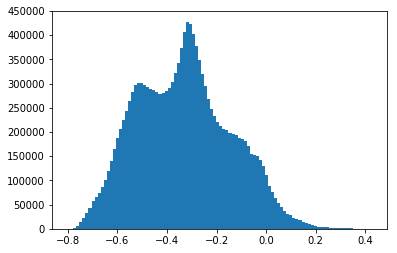

In [72]:
# Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(ndwi_green.ravel(), bins=100);

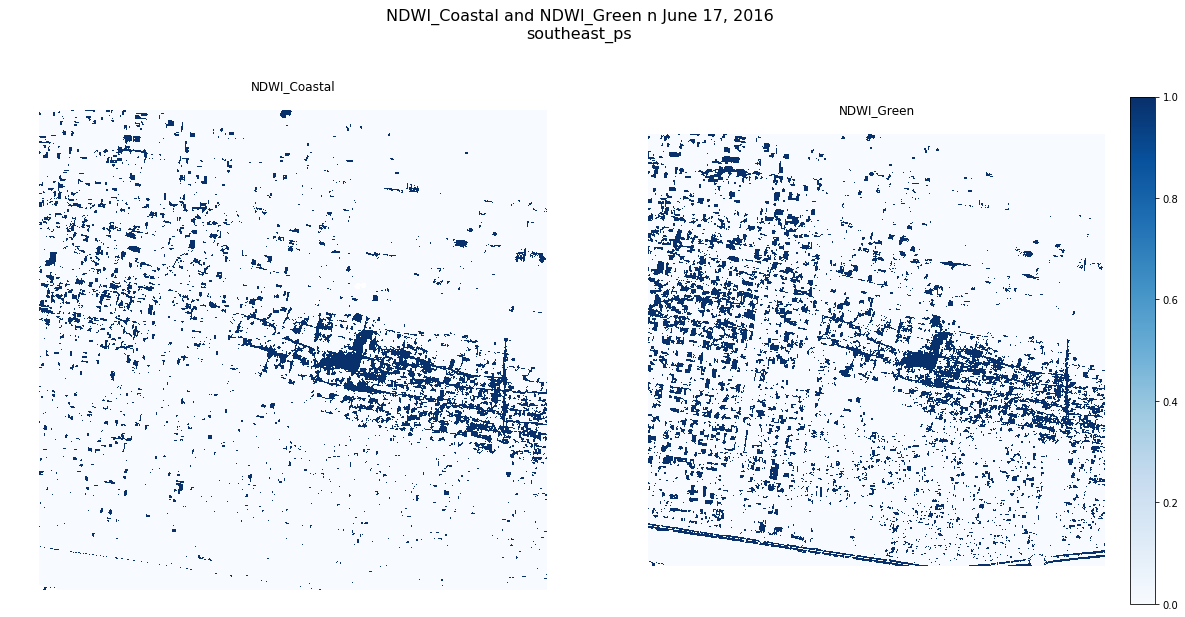

In [73]:
# Plots for NDWI_Coastal  and NDWI_Green Masks
thresh = -0.12
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Coastal and NDWI_Green n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(ndwi_coastal>thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Coastal\n")
ax1.set_axis_off()

ndwi_green_plot = ax2.imshow(ndwi_green>thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Green\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

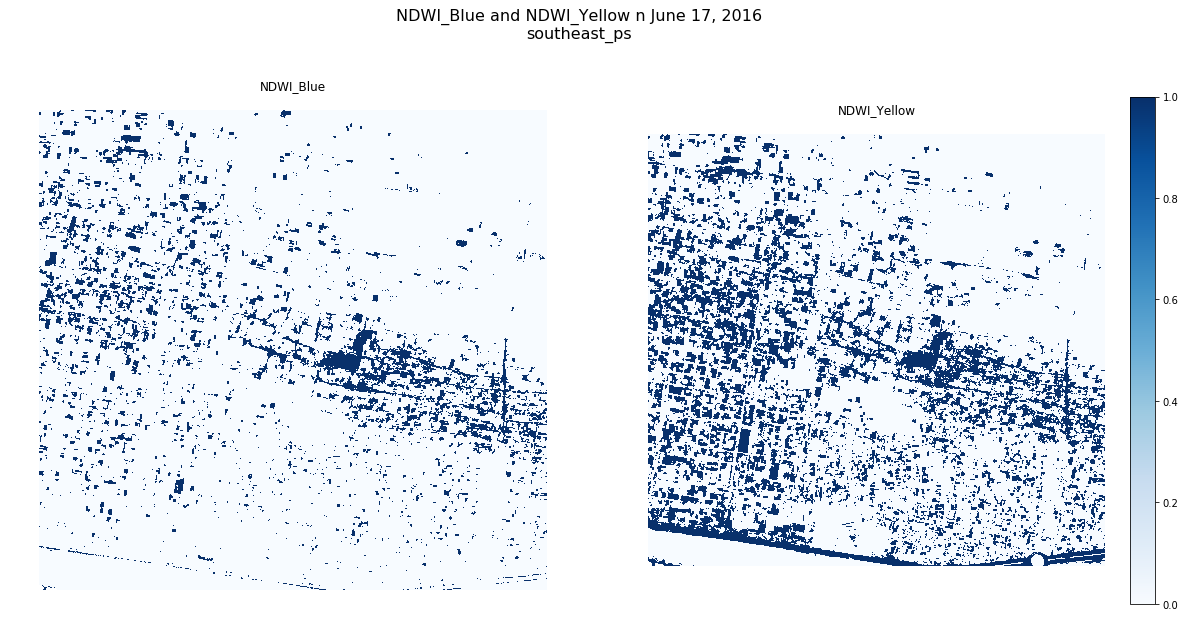

In [74]:
# Plots for NDWI_Coastal  and NDWI_Green Masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Blue and NDWI_Yellow n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(ndwi_blue>thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Blue\n")
ax1.set_axis_off()

ndwi_green_plot = ax2.imshow(ndwi_yellow>=thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Yellow\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

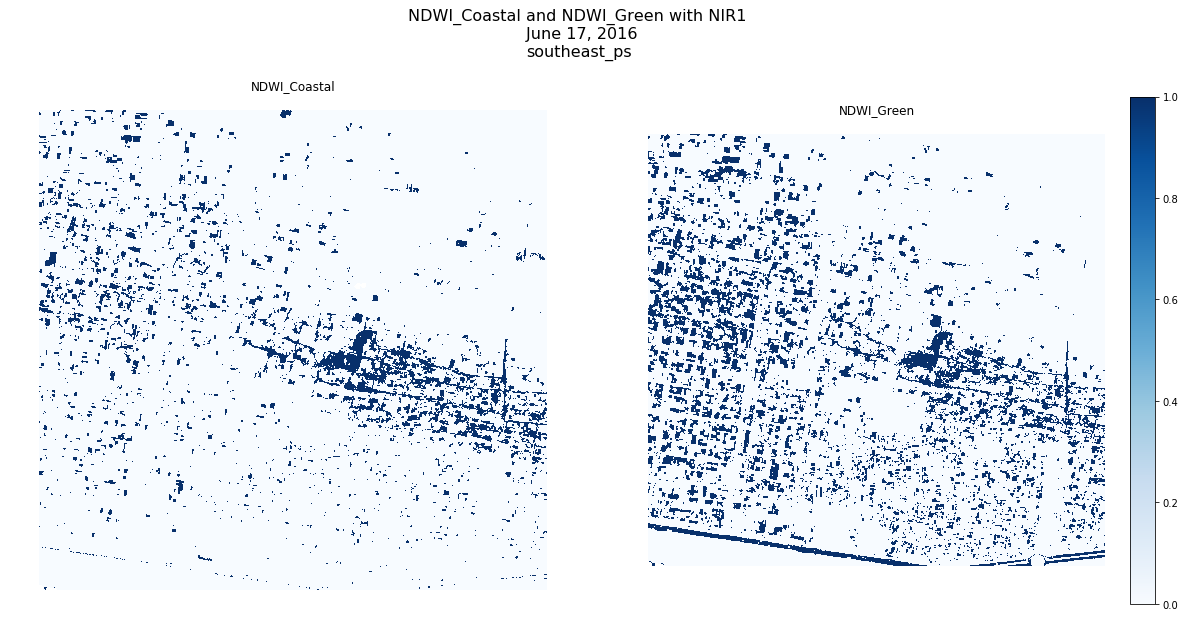

In [75]:
# Plots for NDWI_Coastal  and NDWI_Green Masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Coastal and NDWI_Green with NIR1 \n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(ndwi_coastal_nir1>thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Coastal\n")
ax1.set_axis_off()

ndwi_green_plot = ax2.imshow(ndwi_green_nir1>=thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Green\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

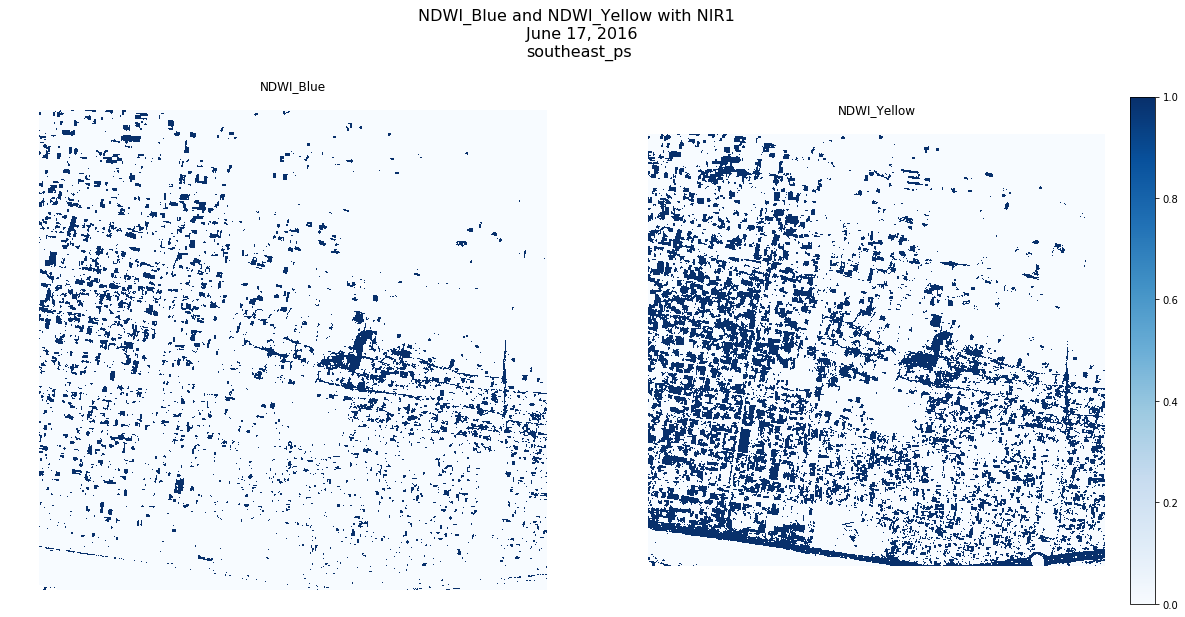

In [76]:
thresh = -0.12
# Plots for NDWI_Blue  and NDWI_Yellow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Blue and NDWI_Yellow with NIR1 \n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(ndwi_blue_nir1>thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Blue\n")
ax1.set_axis_off()

ndwi_green_plot = ax2.imshow(ndwi_yellow_nir1>=thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Yellow\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

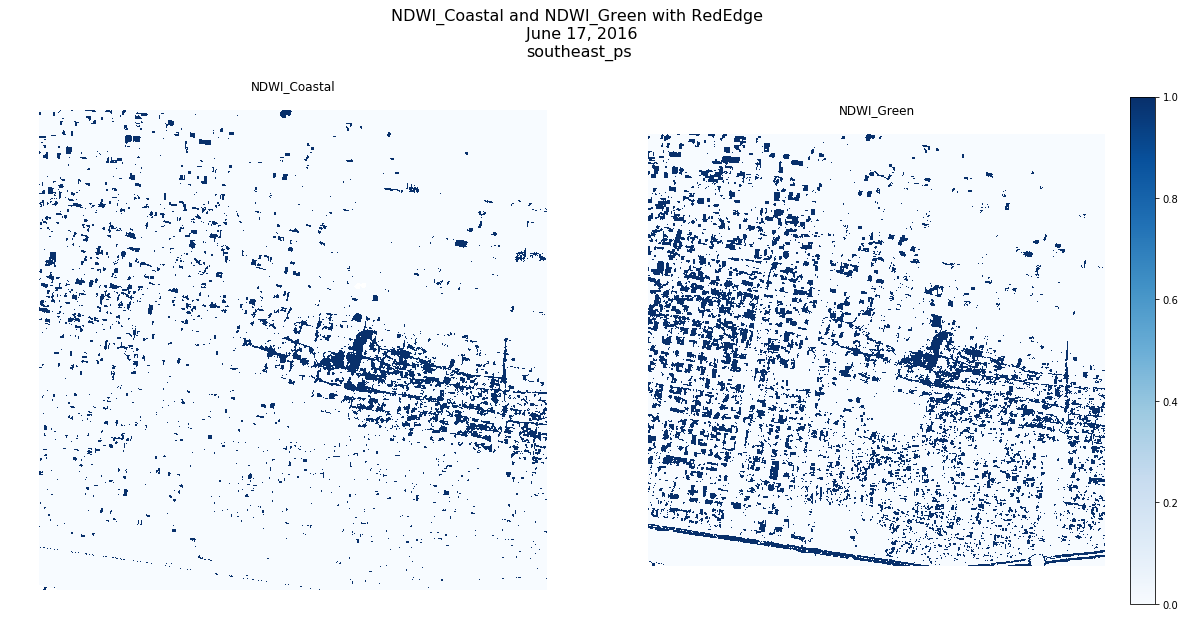

In [77]:
# Plots for NDWI_Coastal  and NDWI_Green Masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Coastal and NDWI_Green with RedEdge \n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(ndwi_coastal_rededge>thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Coastal\n")
ax1.set_axis_off()

ndwi_green_plot = ax2.imshow(ndwi_green_rededge>=thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Green\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

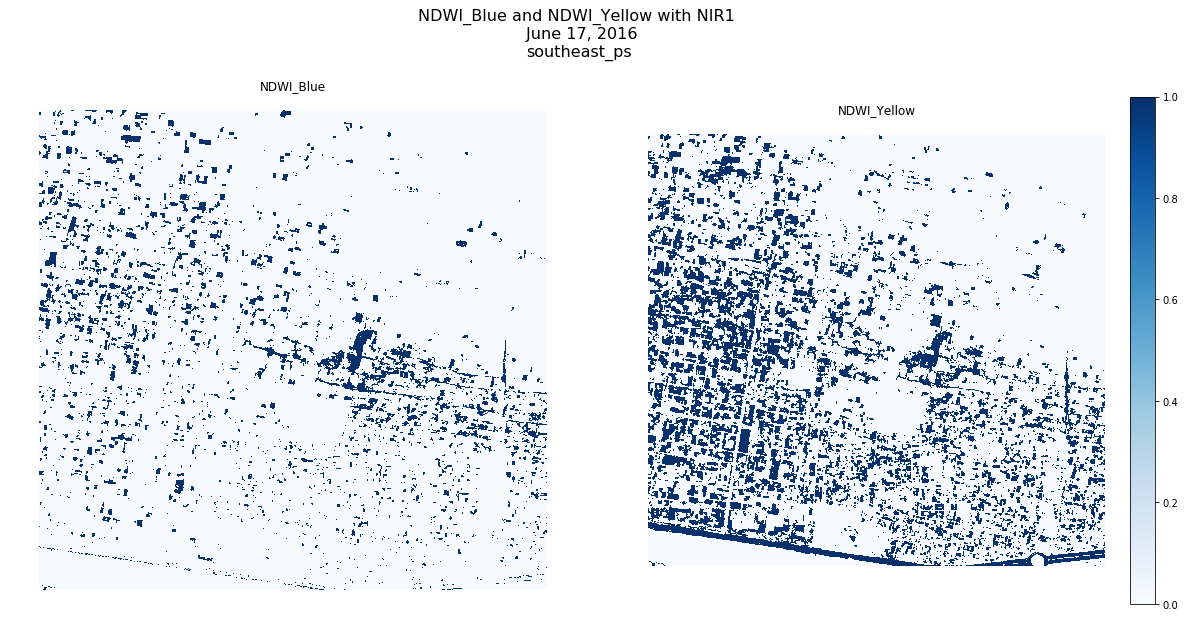

In [78]:
# Plots for NDWI_Blue  and NDWI_Yellow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Blue and NDWI_Yellow with NIR1 \n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(ndwi_blue_rededge>thresh, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Blue\n")
ax1.set_axis_off()

ndwi_green_plot = ax2.imshow(ndwi_yellow_rededge>=-.08, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Yellow\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

In [79]:
ndwi_yellow_mask = (ndwi_yellow>=thresh).astype(int)
ndwi_yellow_nir1_mask =(ndwi_yellow_nir1>=thresh).astype(int)
ndwi_yellow_rededge_mask = (ndwi_yellow_rededge>=thresh).astype(int)

In [80]:
# Write out files
with rio.open(outputs_path+'ndwi_green_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi_green>-0.05).astype(int), 1)
with rio.open(outputs_path+'ndwi_coastal_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi_coastal>-0.05).astype(int), 1)
with rio.open(outputs_path+'ndwi_green_msi_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi_green_msi>-0.05).astype(int), 1)
with rio.open(outputs_path+'ndwi_coastal_msi_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write((ndwi_coastal_msi>-0.05).astype(int), 1)    
with rio.open(outputs_path+'raw_ndwi_green_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_green_msi, 1)
with rio.open(outputs_path+'raw_ndwi_coastal_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_coastal_msi, 1)

In [81]:
with rio.open(outputs_path+'ndwi_green.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_green, 1)
with rio.open(outputs_path+'ndwi_coastal.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_coastal, 1)

## Might want to try adding these to SVM

In [82]:
with rio.open(outputs_path+'ndwi_yellow.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_yellow, 1)
with rio.open(outputs_path+'ndwi_yellow_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_yellow_msi, 1)

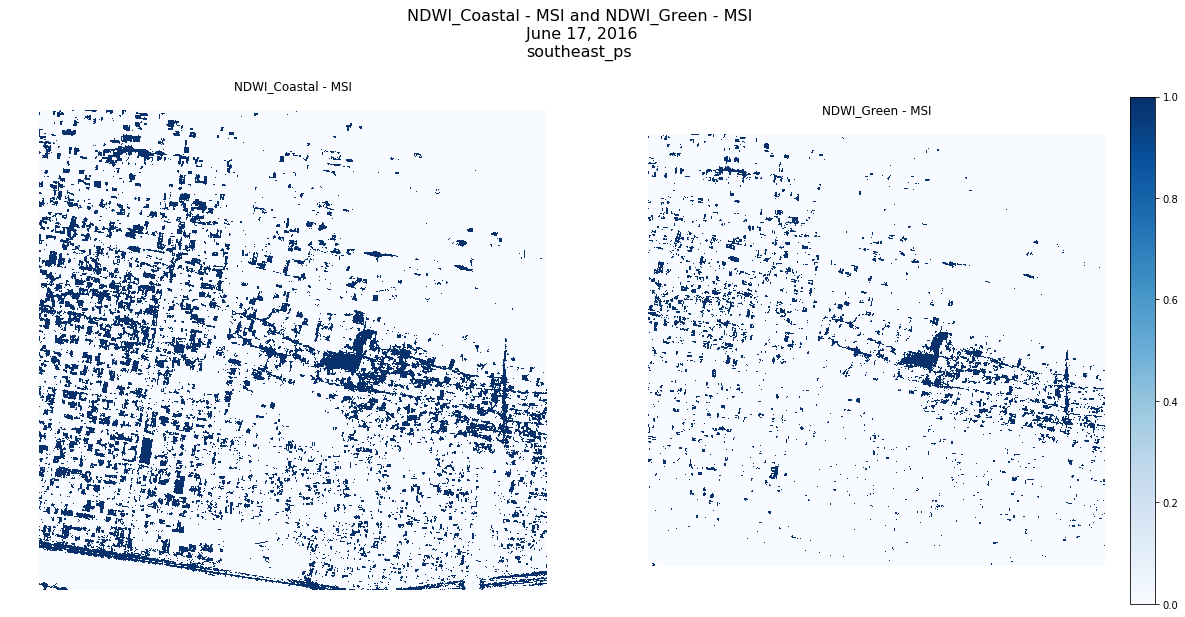

In [83]:
# Compare plots for NDWI_Coastal - MSI and NDWI_Green - MSI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Coastal - MSI and NDWI_Green - MSI\n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(ndwi_yellow_msi>-0.12, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Coastal - MSI\n")
ax1.set_axis_off()

ndwi_green_plot = ax2.imshow(ndwi_green_msi>-0.05, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Green - MSI\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

In [84]:
# Create flood masks based on thresholds
ndwi_coastal_msi_mask = (ndwi_coastal_msi>-0.1).astype(int)
ndwi_green_msi_mask = (ndwi_green_msi>-0.1).astype(int)


# Create flood masks and remove noise 
ndwi_coastal_msi_mask_smoothed = morph_indices.smooth_disk(index_array=ndwi_coastal_msi,threshold=0.01,disk_size=2)
ndwi_green_msi_mask_smoothed = morph_indices.smooth_disk(index_array=ndwi_green_msi,threshold=0.01,disk_size=2)

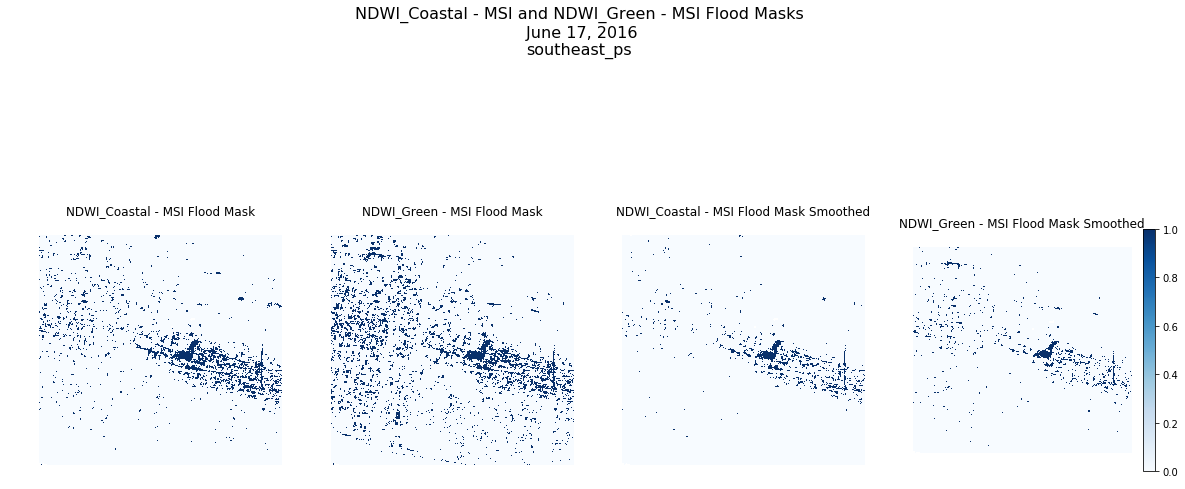

In [85]:
# Compare plots for masks
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20, 10))

plt.suptitle('NDWI_Coastal - MSI and NDWI_Green - MSI Flood Masks\n June 17, 2016\n'+aoi, fontsize=16)

ndwi_coastal_mask_plot = ax1.imshow(ndwi_coastal_msi_mask, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Coastal - MSI Flood Mask\n")
ax1.set_axis_off()

ndwi_green_mask_plot = ax2.imshow(ndwi_green_msi_mask, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Green - MSI Flood Mask\n")
ax2.set_axis_off()

ndwi_coastal_mask_plot = ax3.imshow(ndwi_coastal_msi_mask_smoothed, cmap = 'Blues', vmin = 0, vmax = 1)
ax3.set(title="NDWI_Coastal - MSI Flood Mask Smoothed\n")
ax3.set_axis_off()

ndwi_green_mask_plot = ax4.imshow(ndwi_green_msi_mask_smoothed, cmap = 'Blues', vmin = 0, vmax = 1)
ax4.set(title="NDWI_Green - MSI Flood Mask Smoothed\n")
ax4.set_axis_off()


fig.colorbar(ndwi_coastal_mask_plot, fraction=.05)
plt.show()

In [86]:
# Write out files
with rio.open(outputs_path+'ndwi_green_msi_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(ndwi_green_msi_mask, 1)
with rio.open(outputs_path+'ndwi_coastal_msi_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(ndwi_coastal_msi_mask, 1)

In [87]:
# from skimage import measure
# from skimage import morphology

# patch_labels = measure.label(ndwi_green_msi_mask, background=0) 
# props = measure.regionprops(patch_labels) 
# # patchsize_thresh = 30
# small_patches = []
# for prop in props:
#     if prop.area < 2:
#         small_patches.append(prop.label)
# len(small_patches)

# # Remove all small objects less than a certain size
# flood_cleaned = morphology.remove_small_objects(patch_labels, min_size=500)

# # Plot flood label layer 
# fig, ax = plt.subplots(figsize=(20,10))
# flood_cleaned_plot = ax.imshow(flood_cleaned, cmap='Spectral')
# ax.set(title="Flood Labels, June 17, 2016\n"+aoi+"\n")
# # ax.set_axis_off()
# plt.show()

# Calculate MBI 

0.76014537


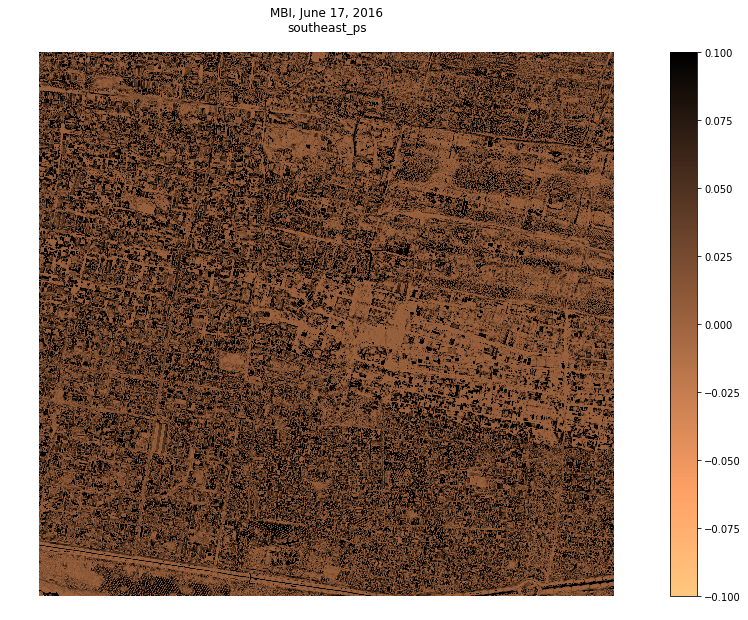

In [88]:
# Calculate MBI
mbi = morph_indices.calc_mbi(raster_input=all_bands_cl_free,s_min=2, s_max=52,s_delta=5)
print(mbi.max())

# Plot MBI
fig, ax = plt.subplots(figsize=(20,10))
mbi_plot = ax.imshow(mbi, cmap='copper_r',
                vmin=0, vmax=0)
fig.colorbar(mbi_plot, fraction=0.05)
ax.set(title="MBI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

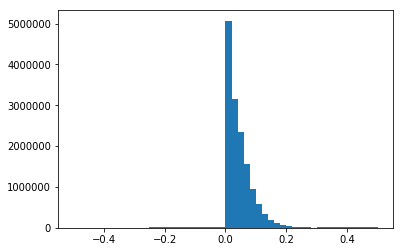

In [89]:
# Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(mbi.ravel(), bins=[-0.5,-0.25,0,0.02,.04,.06,.08,.10,.12,.14,.16,.18,.20,.22,.24,.26,.28,.30,.5]);

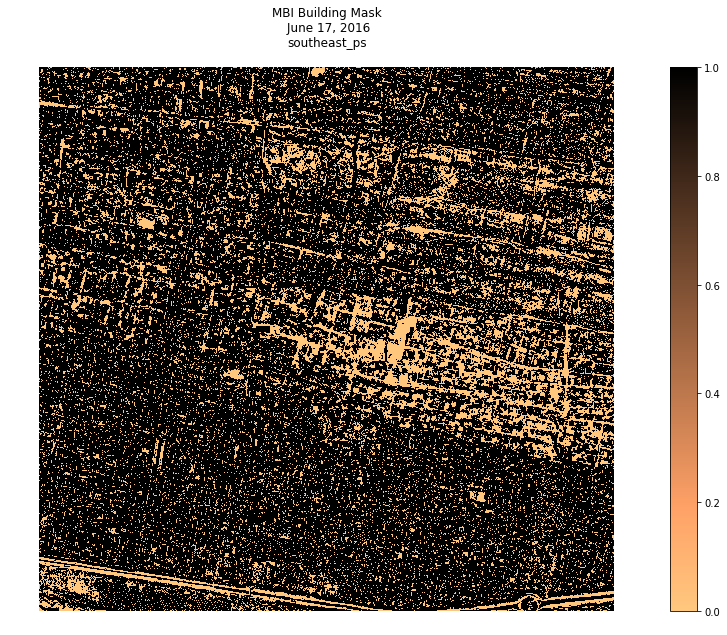

In [90]:
# Develop shadow mask for MBI >=0.025 and apply morphological opening
# threshold = 0.015
building_mask = morph_indices.smooth_disk(index_array=mbi,threshold=0.005,disk_size=3)

# Plot building mask layer 
fig, ax = plt.subplots(figsize=(20,10))
building_plot = ax.imshow(building_mask, cmap='copper_r',
                vmin=0, vmax=1)
fig.colorbar(building_plot, fraction=.05)
ax.set(title="MBI Building Mask\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [91]:
# Write out MBI and building mask files
with rio.open(outputs_path+'mbi.tif', 'w', **files_out_meta) as dst:
    dst.write(mbi, 1)
with rio.open(outputs_path+'raw_mbi.tif', 'w', **files_out_meta) as dst:
    dst.write(mbi, 1)
with rio.open(outputs_path+'building_mask.tif', 'w', **masks_out_meta) as dst:
    dst.write(building_mask, 1)

In [92]:
# Develop building mask for MBI > threshold and apply morphological opening
from skimage.morphology import opening, disk

building = (mbi>=0.065).astype(int)
selem_building = disk(1)
building_opened = opening(building, selem_building)

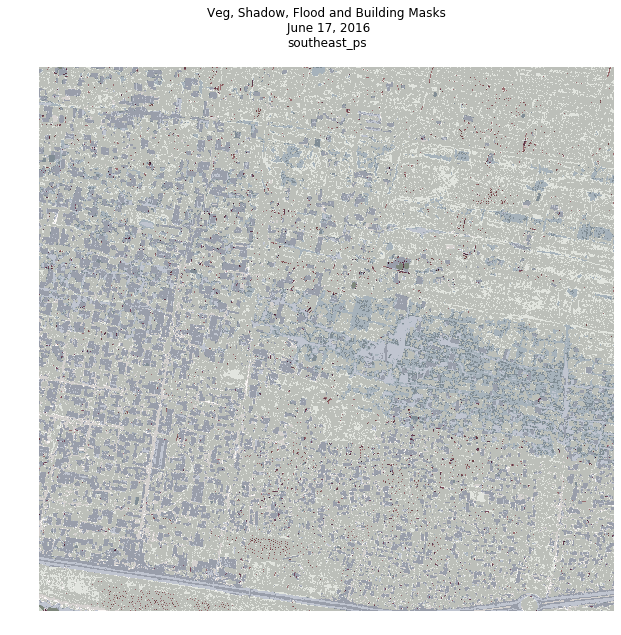

In [93]:
# Plot vegetation and building masks
fig, ax = plt.subplots(figsize=(20,10))

ndvi_plot = ax.imshow(vegetation_mask==1, cmap = 'Greens')
mbi_plot = ax.imshow(building_mask==1, cmap='Greys',alpha = 0.6)
flood_plot = ax.imshow(flood_mask==1, cmap='Blues', alpha=0.5)
msi_plot = ax.imshow(shadow_mask==1, cmap='Reds',alpha=0.5)

ax.set(title="Veg, Shadow, Flood and Building Masks\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

## Attempts at combining masks into a single image. 
Hierarchy is as follows:
Shadow_mask, flood_mask, veg_mask, building_mask

Which means..
values of 5, 10, 15, 20, 30, 60, 120 --> 5 (shadow)
values of 4, 8, 12, 24 --> 4 (water)
values of 3, 6 --> 3 (vegetation)
values of 2 --> 2 (building)

# Swapped in NDWI_yellow for "flood mask" from cloud to street
Improved accuracy score
original was flood_mask_comb = flood_mask*4

In [94]:
shadow_mask_comb = shadow_mask*5
flood_mask_comb = ndwi_yellow_mask*4
veg_mask_comb = vegetation_mask*3
building_mask_comb = building_mask*2
index_comb = shadow_mask_comb*flood_mask_comb*veg_mask_comb*building_mask_comb
np.unique(building_mask_comb)

array([0, 2])

In [95]:
shadow_mask_comb = np.where(shadow_mask_comb==0,1,shadow_mask_comb)
flood_mask_comb = np.ma.where(flood_mask_comb==0,1,flood_mask_comb)
veg_mask_comb = np.where(veg_mask_comb==0,1,veg_mask_comb)
building_mask_comb = np.where(building_mask_comb==0,1,building_mask_comb)
index_comb = shadow_mask_comb*flood_mask_comb*veg_mask_comb*building_mask_comb
np.unique(index_comb)

masked_array(data=[1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 24, 30, 40, 60,
                   120, --],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                    True],
       fill_value=999999)

In [96]:
index_comb = np.where(index_comb>=30,5,index_comb)
index_comb = np.where(index_comb==10,5,index_comb)
index_comb = np.where(index_comb==15,5,index_comb)
index_comb = np.where(index_comb==20,5,index_comb)
index_comb = np.where(index_comb==24,4,index_comb)
index_comb = np.where(index_comb==12,4,index_comb)
index_comb = np.where(index_comb==8,2,index_comb)
index_comb = np.where(index_comb==6,3,index_comb)
index_comb

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]])

In [97]:
threshold_outputs_path = os.path.join(band_path, "explorations_outputs\\threshold\\")
flood_only_index_comb = np.where(index_comb!=4,0,index_comb)
with rio.open(threshold_outputs_path+'flood_only_index_comb.tif', 'w', **files_out_meta) as dst:
    dst.write(flood_only_index_comb.astype('float32'), 1)

CPLE_OpenFailedError: Attempt to create new tiff file '..\data\southeast_ps\explorations_outputs\threshold\flood_only_index_comb.tif' failed: No such file or directory

In [ ]:
from matplotlib.colors import ListedColormap
# Plot combined masks
fig,ax = plt.subplots(figsize=(20,10))
cmap = ListedColormap(['white','royalblue'])
ax.imshow(flood_only_index_comb, cmap = cmap)
ax.set(title="Combined Masks\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
# Plot combined masks
fig,ax = plt.subplots(figsize=(20,10))
cmap = ListedColormap(['white','grey','darkseagreen','royalblue','m'])
ax.imshow(index_comb, cmap = cmap)
ax.set(title="Combined Masks\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [ ]:
# Make RGB-stack for plotting with threshold results
rgb_bands = glob(band_path+"*band_[1,2,4]*")
rgb_bands.sort()
rgb_bands_path = os.path.join(outputs_path, aoi + "_rgb_bands.tif")
rgb_bands, rgb_bands_meta = es.stack(rgb_bands,
                                             rgb_bands_path)

fig,ax = plt.subplots(figsize=(20,10))
ep.plot_rgb(rgb_bands,rgb=(2, 1, 0), ax=ax)
cmap = ListedColormap(['none','none','none','steelblue','m'])
ax.imshow(index_comb, cmap = cmap)
ax.set_axis_off()
plt.show()

# Calculate flooded surface area

In [ ]:
no_data_pix = (index_comb==1).sum()
building_pix = (index_comb==2).sum()
veg_pix = (index_comb==3).sum()
flood_pix = (index_comb==4).sum()
shadow_pix = (index_comb==5).sum()

# WorldView-2 resolution for panchromatic images is 0.46m
res = 0.46*0.46
flood_area = flood_pix*res
flood_area

In [ ]:
threshold_outputs_path = os.path.join(band_path, "outputs\\threshold\\")
try:
    os.makedirs(threshold_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")
with rio.open(threshold_outputs_path+'index_comb_yellow.tif', 'w', **files_out_meta) as dst:
    dst.write(index_comb.astype('float32'), 1)
with rio.open(threshold_outputs_path+'index_comb_yellow.tif', 'w', **files_out_meta) as dst:
    dst.write(index_comb.astype('float32'), 1)

Trial using SDI from Shahi et al. 2014. *A Novel Spectral Index for Automatic Shadow Detection in Urban Mapping Based On  WorldView-2 Satellite Imagery.* World Academy of Science, Engineering and Technology International Journal of Environmental and Ecological Engineering Vol:8, No:10.

In [ ]:
sdi = ((nearir2_scaled-blue_cl_free)/(nearir2_cl_free+blue_cl_free))-nearir1_cl_free
print(sdi.max())

In [ ]:
# # Plot histogram to explore distribution of MSI values
# fig,ax = plt.subplots()
# plt.hist(sdi.ravel());

In [ ]:
# Plot SDI
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(sdi>0.15, cmap='Spectral',
                vmin=0, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="SDI\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

Appears to catch vegetation with the shadow.

In [ ]:
# Develop shadow mask for SDI and apply morphological opening to remove noise
sdi_mask = morph_indices.smooth_disk(index_array=sdi,threshold=0.15,disk_size=4)

# Plot SDI mask
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(sdi_mask, cmap='Oranges',
                vmin=0, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="SDI Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [ ]:
flood_sdi = ndwi_green-sdi
# Plot ndwi_green - sdi
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(flood_sdi>0, cmap='Blues',
                vmin=-1, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="NDWI_Green - SDI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [ ]:
ndwi_green_sdi_mask_smoothed = morph_indices.smooth_disk(index_array=flood_sdi,threshold=0.25,disk_size=4)
# Plot SDI mask
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(ndwi_green_sdi_mask_smoothed, cmap='Blues',
                vmin=0, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="NDWI_Green SDI Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [ ]:
dark = dark[np.newaxis,:]
msi = msi[np.newaxis,:]
mbi = mbi[np.newaxis,:]
ndwi_coastal_msi = ndwi_coastal_msi[np.newaxis,:]
ndwi_green_msi = ndwi_green_msi[np.newaxis,:]

stack = [dark,msi,mbi,ndwi_coastal_msi,ndwi_green_msi]
feature_stack = np.vstack(stack)
feature_stack.shape
stack_im = np.rollaxis(feature_stack, 0, 3)
feature_image = stack_im.reshape(-1,5)
feature_image

In [ ]:
ndwi_green_msi